# Choroid Plexus and CSF

## Set Up

### Imports

In [1]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
from pathlib import Path
from pyprocessmacro import Process

import numpy as np
import pyperclip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from IPython.display import Markdown, HTML, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess

from reload_recursive import reload_recursive
import sys
import os
from my_python_utils import smart_title

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace


#### Reload modules

In [2]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

# import utils
from utils import zscore
from my_namespace import presentation_cols, presentation_cols_both_ps, colors

#### Load Data

##### Clinical and Volumes

In [3]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/3-CP_CSF_analysis"
)
if not fig_path.exists():
    os.makedirs(fig_path)

data = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")


MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]


p = "<p style='font-family: Mononoki Nerd Font Mono;line-height: 1.3;font-size: 14px;'>"

### Functions

In [4]:
def plot_betas(
    coefficients,
    lower_ci,
    upper_ci,
    labels,
    legend_label="",
    fig=None,
    ax=None,
    jitter=0,
    ylabel="β",
    xlabel="Compartment",
    title="Correlations between CP and CSF Compartments",
    figsize=(8, 6),
    connect_points=False,
    point_color=colors["grey3"],
    ecolor=colors["grey4"],
    line_color=colors["darkest blue2"],
    fontname="Source Sans 3",
    fig_transparent=False,
    axs_transparent=False,
):
    """
    Plot partial correlation coefficients with confidence intervals.

    Parameters
    ----------
    coefficients : array-like
        Point estimates (e.g., partial correlation coefficients)
    lower_ci : array-like
        Lower confidence interval bounds
    upper_ci : array-like
        Upper confidence interval bounds
    labels : list of str
        X-axis labels for each point
    ylabel : str, optional
        Y-axis label
    title : str, optional
        Plot title
    figsize : tuple, optional
        Figure size (width, height)
    connect_points : bool, optional
        Whether to draw lines connecting the points

    Returns
    -------
    fig, ax : matplotlib Figure and Axes objects
    """
    plt.rcParams["font.family"] = fontname
    # Convert to numpy arrays for easier manipulation
    coefficients = np.array(coefficients)
    lower_ci = np.array(lower_ci)
    upper_ci = np.array(upper_ci)

    # Create evenly spaced x values
    x = np.arange(len(coefficients))
    x = x + jitter * (x[1] - x[0])

    # Calculate error bar lengths
    y_lower = coefficients - lower_ci
    y_upper = upper_ci - coefficients

    # Create the plot
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    if fig_transparent:
        fig.patch.set_alpha(0.0)  # Make figure background transparent
    if axs_transparent:
        ax.patch.set_alpha(0.0)  # Make axes background transparent

    # Optionally connect points with a line
    if connect_points:
        ax.plot(
            x, coefficients, "-", color=line_color, linewidth=2, alpha=0.6, zorder=1
        )

    # Plot error bars and points
    ax.errorbar(
        x,
        coefficients,
        yerr=[y_lower, y_upper],
        fmt="o",
        markersize=10,
        color=point_color,
        ecolor=ecolor,
        capsize=6,
        capthick=2.5,
        linewidth=2.5,
        markeredgewidth=2,
        markeredgecolor="white",
        zorder=2,
        label=legend_label
    )

    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_xlabel(xlabel, fontsize=14, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=14, fontweight="bold", labelpad=10)

    if title is not None:
        ax.set_title(title, fontsize=15, fontweight="bold", pad=20)

    # Add horizontal line at zero for reference
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1, alpha=0.5)

    plt.tight_layout()

    return fig, ax


def display_results(result, outcome, predictor, covariates, heading=None, sort=False, ascending=False):
    formula = regutils.formula_string(outcome, predictor, covariates)
    if sort:
        display_order = result["coef"].sort_values(ascending=ascending).index
    else:
        display_order = result.index
    if heading is not None:
        display(Markdown(heading))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

In [5]:
def run_R_script(p1, p2, p12, nobs):
    """
    Call R script to run Williams-Hotelling test and return p-value.

    Parameters:
    -----------
    p1 : float
        First correlation coefficient
    p2 : float
        Second correlation coefficient
    p12 : float
        Correlation between the two variables
    nobs : int
        Number of observations

    Returns:
    --------
    float
        The p-value from the Williams-Hotelling test
    """
    # Path to the R script (adjust this to where your R script is located)
    r_script_path = (
        "/home/srs-9/Projects/ms_mri/analysis/thalamus/run_williams_hotelling.R"
    )

    # Convert arguments to strings
    args = [str(p1), str(p2), str(p12), str(nobs)]

    # Call R script
    try:
        result = subprocess.run(
            ["Rscript", r_script_path] + args,
            capture_output=True,
            text=True,
            check=True,
        )

        # Parse the output (p-value)
        p_value = float(result.stdout.strip())
        return p_value

    except subprocess.CalledProcessError as e:
        print(f"Error running R script: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        raise
    except ValueError as e:
        print(f"Error parsing R output: {e}")
        print(f"R output was: {result.stdout}")
        raise


def thalamus_influence_analysis(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
        residualized_vars[var] = regutils.residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = ["medial", "posterior", "anterior", "ventral"]
    working_structs = structs.copy()

    nuclei_comps = {}
    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"{struct} vs THALAMUS_1"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"{struct} vs THALAMUS_1"] >= 0.05:
            sign = "="
        elif pearson_results[struct][0] > pearson_results["THALAMUS_1"][0]:
            sign = "<"
        else:
            sign = ">"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
                pearson_results[struct1][0],
                pearson_results[struct2][0],
                stats.pearsonr(residualized_vars[struct1], residualized_vars[struct2])[
                    0
                ],
                nobs,
            )
            if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
                sign = "="
            elif pearson_results[struct1][0] > pearson_results[struct2][0]:
                sign = "<"
            else:
                sign = ">"
            nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}

    return pearson_results, thalamus_comps, nuclei_comps


def thalamus_influence_analysis_all_nuclei(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in hips_thomas_ref[thalamic_nuclei].to_list() + [
        "THALAMUS_1",
        influenced_var,
    ]:
        residualized_vars[var] = regutils.residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = hips_thomas_ref[thalamic_nuclei]
    working_structs = structs.copy()

    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"{struct} vs THALAMUS_1"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"{struct} vs THALAMUS_1"] >= 0.05:
            sign = "="
        elif pearson_results[struct][0] > pearson_results["THALAMUS_1"][0]:
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    return pearson_results, thalamus_comps

## Regressions on CSF volumes

Peripheral CSF segmentation was obtained starting from the `FAST` CSF segmentation, then subtracting the lateral, third, and fourth ventricles and also label 24 from Freesurfer's `aseg.auto_noCCseg` segmentation (technically Fastsurfer's)

### Does CP drive central atrophy?

Previous analysis showed that CP is very strongly associated with LV; in fact, of all the variables I'm looking at, LV is the one with the strongest association with CP. Both CP and LV enlarge in MS. We know that LV enlargement can be indicative of a few different pathologic processes.

1. Overproduction of CSF
2. Atrophy
3. CSF obstruction

Also, atrophy associated with ventricular enlargement could be global or central. 

#### CSF Subcompartments

Given the relationship between CP and regional thalamic atrophy, we aimed to determine whether this reflected localized expansion of the ventricles proximal to the CP or a global ex-vacuo phenomenon affecting all periventricular structures. 

Each CSF compartment was regressed on CP or other variables of interest (e.g. T2LV) with WBV as an additional covariate. 

In [27]:
headings = {
    "CP": "##### CP as the main predictor",
    "T2LV_log1p": "##### T2LV as the main predictor",
}

def display_csf_compartment_results(
    all_results, all_covariates, predictor, control_name, heading=None
):
    if heading == "get":
        heading = headings[predictor]
    covariates = all_covariates[control_name]
    results = all_results[control_name]
    result = results[predictor]
    display_results(result, "outcome", predictor, covariates, heading)


def plot_csf_compartment_results(
    all_results,
    predictor,
    control_name,
    jitter=0,
    point_color=colors["grey3"],
    ecolor=colors["grey4"],
    line_color=colors["darkest blue2"],
    legend_label="",
    ylabel="β",
    xlabel="Compartment",
    connect_points=False,
    save=False,
    title="",
    sup_title_y=1.05,
    ax_title="",
    fig=None,
    ax=None,
):
    results = all_results[control_name]
    plot_data = results[predictor]
    save_name = f"Correlations between {predictor} and CSF - {control_name} control.png"
    fig, ax = plot_betas(
        coefficients=plot_data["coef"],
        lower_ci=plot_data["llci"],
        upper_ci=plot_data["ulci"],
        jitter=jitter,
        point_color=point_color,
        ecolor=ecolor,
        line_color=line_color,
        fig=fig,
        ax=ax,
        labels=[
            "Lateral\nVentricles",
            "Interthalamic\nCSF",
            "Third\nVentricle",
            "Fourth\nVentricle",
            "Subarachnoid\nCSF",
        ],
        legend_label=legend_label,
        title=None,
        ylabel=ylabel,
        xlabel=xlabel,
        connect_points=connect_points,
        fig_transparent=False,
        axs_transparent=False,
    )
    if title == "":
        title = f"Correlation between {predictor} and CSF compartments"
    fig.suptitle(
        title, fontsize=15, fontweight="bold", y=sup_title_y
    )  # Adjust y position if needed
    
    if ax_title == "":
        ax_title = f"Control {control_name}"
    ax.set_title(ax_title, fontsize=14, fontstyle="italic", loc="left")

    if save:
        fig.savefig(
            fig_path / save_name, dpi=300, bbox_inches="tight", transparent=False
        )
    return fig, ax

In [33]:
outcomes = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
which_lesion_vol = "periV_T2LV_log1p"
predictors = [
    "CP",
    "T2LV_log1p",
    "periV_T2LV_log1p",
    "juxcort_T2LV_log1p",
    "subcort_T2LV_log1p",
    "infraT_T2LV_log1p",
    "WTV",
    "WBV",
    "PRL",
]
all_covariates = {
    "basic": ["age", "Female", "tiv"],
    "WBV": ["WBV", "age", "Female", "tiv"],
    "CP": ["CP", "age", "Female", "tiv"],
    "CP+WBV": ["CP", "WBV", "age", "Female", "tiv"],
    "CP+T2LV+WBV": ["CP", "T2LV_log1p", "WBV", "age", "Female", "tiv"],
    "CP+periV_T2LV+WBV": ["CP", "periV_T2LV_log1p", "WBV", "age", "Female", "tiv"],
    "CP+juxcort_T2LV+WBV": ["CP", "juxcort_T2LV_log1p", "WBV", "age", "Female", "tiv"],
    "CP+subcort_T2LV+WBV": ["CP", "subcort_T2LV_log1p", "WBV", "age", "Female", "tiv"],
    "CP+infraT_T2LV+WBV": ["CP", "infraT_T2LV_log1p", "WBV", "age", "Female", "tiv"],
}

model_data = zscore(data[MS_patients], skip_vars=["PRL"])

all_results = {}
all_models = {}
for control_name, covariates in all_covariates.items():
    _, all_results[control_name], all_models[control_name] = regutils.run_regressions(
        model_data, outcomes, predictors, covariates=covariates, to_check_vif=False
    )

##### CP's association with CSF compartments

The first table shows the results of using basic covariates. CP enlargement was associated with expansion of all CSF compartments, but the strength of the relationship decreased distal to the lateral ventricles.

The second table and the plot shows the results when controlling WBV. In this case, CP enlargement was associated with *smaller* peripheral CSF spaces when WBV was held constant.  

Repeat the same analysis using T2LV to predict volumes of CSF compartments. T2LV has a similar trend in its relationship to these compartments where it predicts greater expansion of the proximal compartments, but the direction reverses distal when whole brain atrophy is held constant

Text(0.5, 1.02, 'MS Patients')

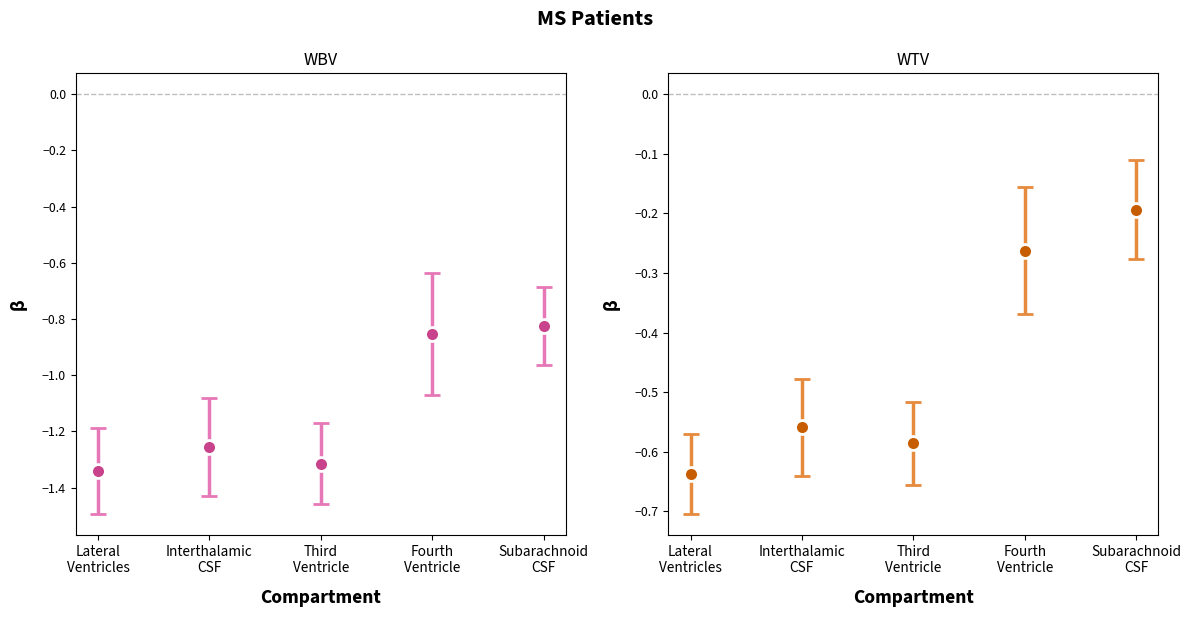

In [47]:
control_name = "basic"
predictor = "WBV"
result = all_results[control_name][predictor]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
plot_csf_compartment_results(
    all_results,
    predictor,
    control_name,
    title=None,
    ax_title=None,
    point_color=colors["dark pink1"],
    ecolor=colors["light pink1"],
    line_color=colors["darkest red2"],
    connect_points=False,
    legend_label="WBV",
    fig=fig,
    ax=ax
)
ax.set_title("WBV", fontsize=13)


predictor = "WTV"
result = all_results[control_name][predictor]
ax = axes[1]
plot_csf_compartment_results(
    all_results,
    predictor,
    control_name,
    title=None,
    ax_title=None,
    point_color=colors["dark orange2"],
    ecolor=colors["light orange2"],
    line_color=colors["darkest red2"],
    connect_points=False,
    legend_label="WBV",
    fig=fig,
    ax=ax
)
ax.set_title("WTV", fontsize=13)

fig.suptitle("MS Patients", fontweight='bold', y=1.02, fontsize=16)

```R
outcome ~ CP + T2LV_log1p + WBV + age + Female + tiv
```


| outcome      |    coef |   p_fdr |     se | ci                  |   R2 |
|:-------------|--------:|--------:|-------:|:--------------------|-----:|
| LV_log       |  0.4137 | 2.3e-25 | 0.0392 | [0.337, 0.491]      | 0.67 |
| interCSF_log |  0.192  | 0.00016 | 0.048  | [0.0979, 0.286]     | 0.4  |
| thirdV_log   |  0.1087 | 0.015   | 0.0414 | [0.0275, 0.19]      | 0.53 |
| fourthV_log  |  0.0112 | 0.85    | 0.0604 | [-0.107, 0.13]      | 0.23 |
| periCSF_log  | -0.0695 | 0.062   | 0.0354 | [-0.139, -0.000216] | 0.69 |

```R
outcome ~ T2LV_log1p + CP + WBV + age + Female + tiv
```


| outcome      |    coef |   p_fdr |     se | ci                |   R2 |
|:-------------|--------:|--------:|-------:|:------------------|-----:|
| LV_log       |  0.1346 | 0.00035 | 0.0358 | [0.0644, 0.205]   | 0.67 |
| interCSF_log |  0.1086 | 0.027   | 0.0474 | [0.0158, 0.201]   | 0.4  |
| thirdV_log   |  0.1364 | 0.00035 | 0.0368 | [0.0643, 0.209]   | 0.53 |
| fourthV_log  |  0.0105 | 0.83    | 0.0488 | [-0.0852, 0.106]  | 0.23 |
| periCSF_log  | -0.1371 | 0.00023 | 0.0336 | [-0.203, -0.0712] | 0.69 |

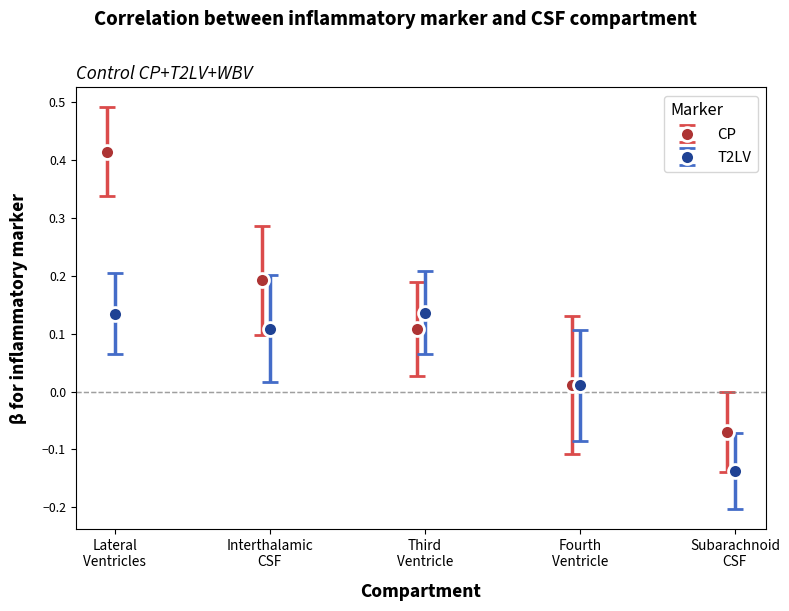

In [81]:
which_lesion_vol = "T2LV"
control_name = f"CP+{which_lesion_vol}+WBV"
covariates = all_covariates[control_name]

predictor = "CP"
result = all_results[control_name][predictor]
display_csf_compartment_results(all_results, all_covariates, predictor, control_name)

fig, ax = plot_csf_compartment_results(
    all_results,
    predictor,
    control_name,
    point_color=colors["darker red2"],
    ecolor=colors["dark red2"],
    line_color=colors["darkest red2"],
    connect_points=False,
    legend_label="CP"
)

predictor = f"{which_lesion_vol}_log1p"
result = all_results[control_name][predictor]
display_csf_compartment_results(all_results, all_covariates, predictor, control_name)
fig, ax = plot_csf_compartment_results(
    all_results,
    predictor,
    control_name,
    jitter=0.05,
    point_color=colors["dark blue1"],
    ecolor=colors["darkish blue1"],
    line_color=colors["darkest blue1"],
    connect_points=False,
    legend_label="T2LV",
    fig=fig,
    ax=ax,
)

title = "Correlation between inflammatory marker and CSF compartment"
sup_title_y = 1.01
fig.suptitle(
        title, fontsize=15, fontweight="bold", y=sup_title_y
    )  # Adjust y position if needed
ax.set_ylabel("β for inflammatory marker")
ax.legend(title="Marker", alignment='left', fontsize=12, title_fontsize=13)

Text(0.5, 1.01, 'Correlation between inflammatory marker and CSF compartment')

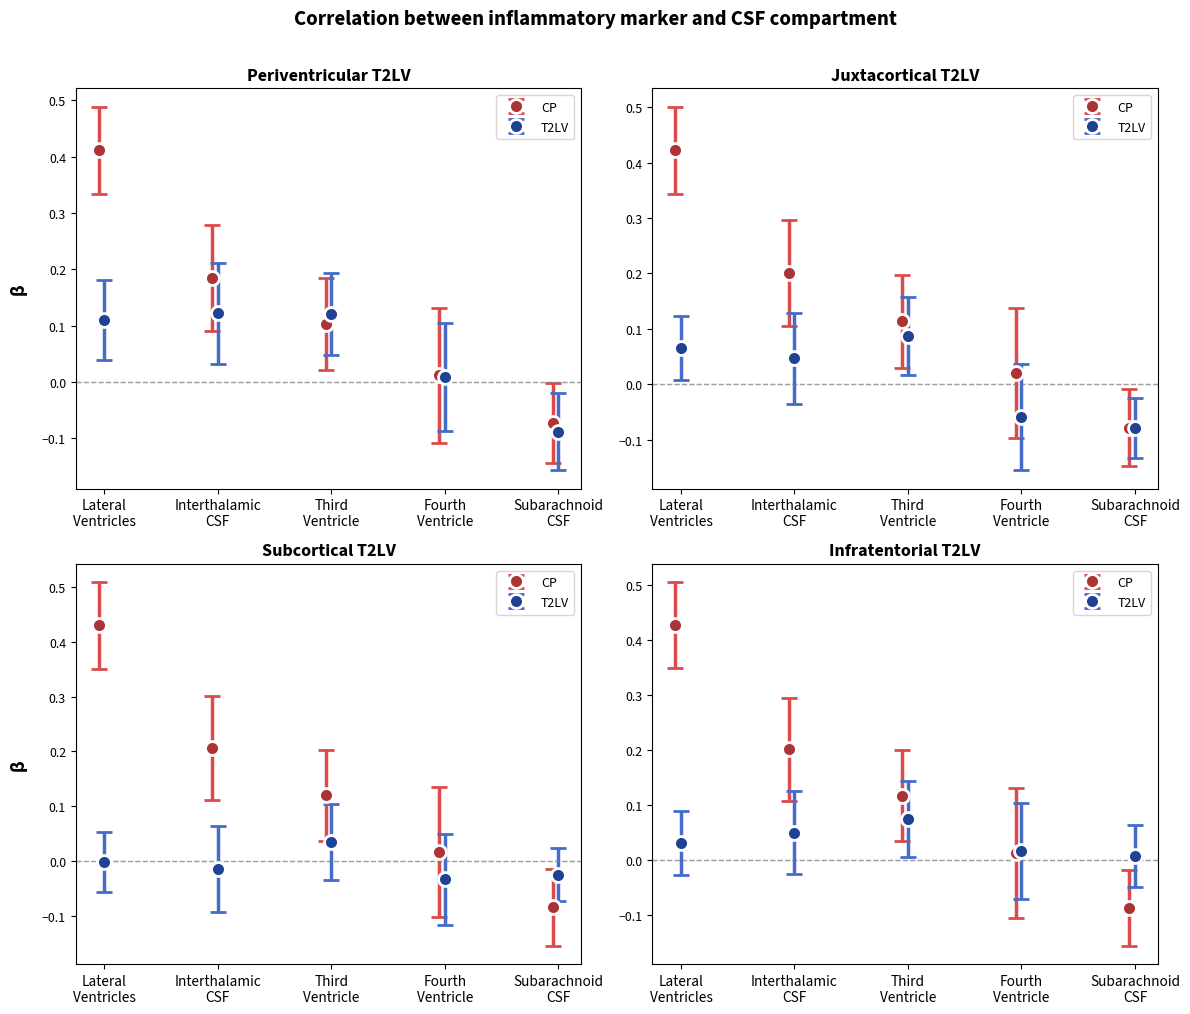

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

lesion_titles = {
    "periV_T2LV": "Periventricular T2LV",
    "juxcort_T2LV": "Juxtacortical T2LV",
    "subcort_T2LV": "Subcortical T2LV",
    "infraT_T2LV": "Infratentorial T2LV",
}

for i, which_lesion_vol in enumerate(["periV_T2LV", "juxcort_T2LV", "subcort_T2LV", "infraT_T2LV"]):
    row, col = np.unravel_index(i, (2,2))
    ax = axes[row, col]
    control_name = f"CP+{which_lesion_vol}+WBV"
    covariates = all_covariates[control_name]

    predictor = "CP"
    result = all_results[control_name][predictor]
    # display_csf_compartment_results(all_results, all_covariates, predictor, control_name)

    plot_csf_compartment_results(
        all_results,
        predictor,
        control_name,
        point_color=colors["darker red2"],
        ecolor=colors["dark red2"],
        line_color=colors["darkest red2"],
        connect_points=False,
        legend_label="CP",
        xlabel=None,
        ylabel=None,
        ax_title=None,
        fig=fig,
        ax=ax,
    )

    predictor = f"{which_lesion_vol}_log1p"
    result = all_results[control_name][predictor]
    # display_csf_compartment_results(all_results, all_covariates, predictor, control_name)
    plot_csf_compartment_results(
        all_results,
        predictor,
        control_name,
        jitter=0.05,
        point_color=colors["dark blue1"],
        ecolor=colors["darkish blue1"],
        line_color=colors["darkest blue1"],
        connect_points=False,
        legend_label="T2LV",
        ax_title=None,
        xlabel=None,
        ylabel=None,
        fig=fig,
        ax=ax,
    )
    if col == 0:
        ax.set_ylabel("β")
    ax.set_title(lesion_titles[which_lesion_vol], fontsize=13, fontweight="bold")
    ax.legend()
title = "Correlation between inflammatory marker and CSF compartment"
sup_title_y = 1.01
fig.suptitle(
        title, fontsize=15, fontweight="bold", y=sup_title_y
    )  # Adjust y position if needed
# ax.legend(title="Marker", alignment='left', fontsize=12, title_fontsize=13)

Text(0.5, 1.01, 'Correlation between inflammatory marker and CSF compartment')

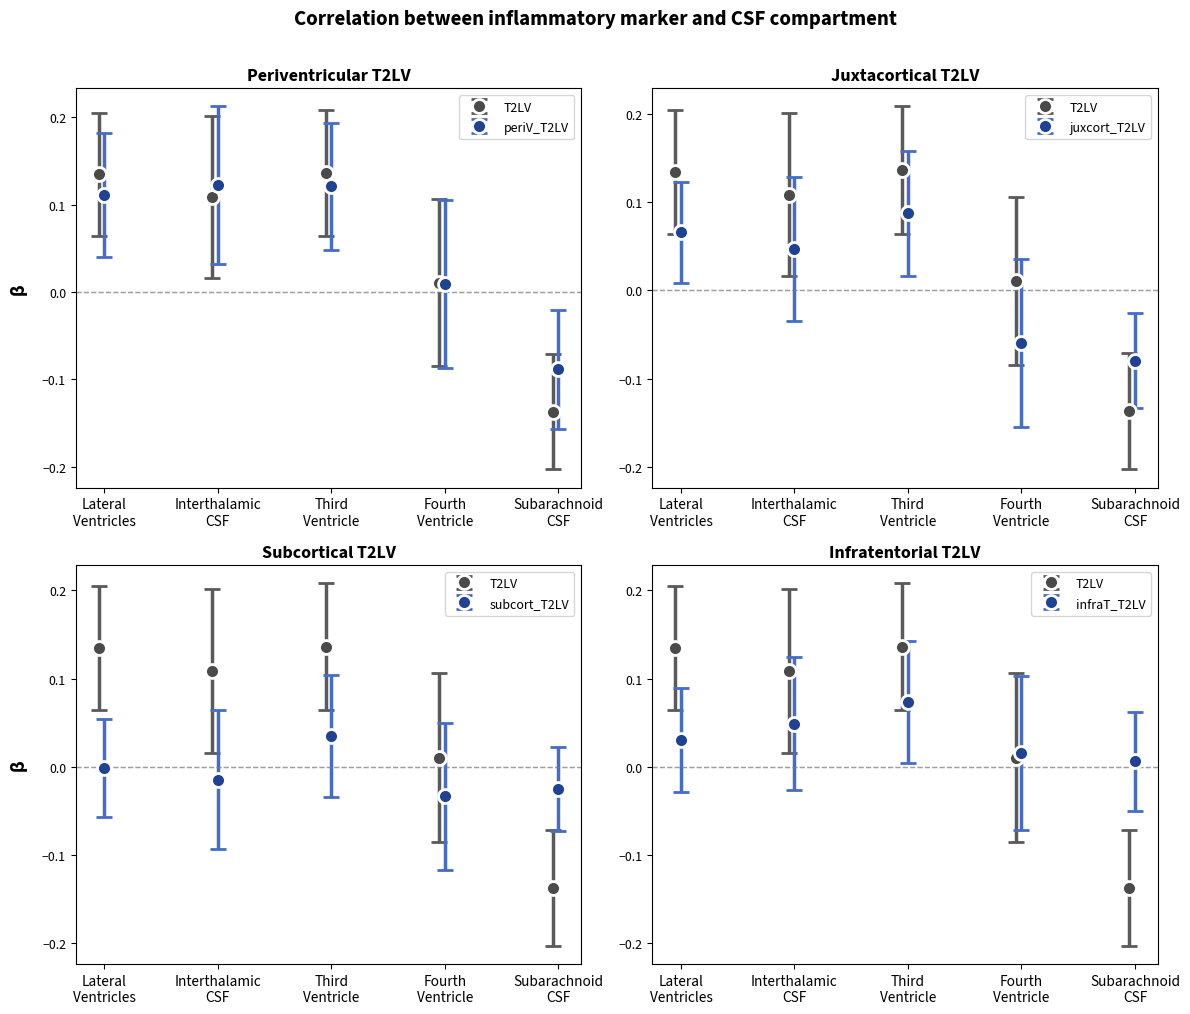

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, which_lesion_vol in enumerate(["periV_T2LV", "juxcort_T2LV", "subcort_T2LV", "infraT_T2LV"]):
    row, col = np.unravel_index(i, (2,2))
    ax = axes[row, col]
    control_name = "CP+T2LV+WBV"
    covariates = all_covariates[control_name]

    predictor = "T2LV_log1p"
    result = all_results[control_name][predictor]
    # display_csf_compartment_results(all_results, all_covariates, predictor, control_name)

    plot_csf_compartment_results(
        all_results,
        predictor,
        control_name,
        # point_color=colors["dark green1"],
        # ecolor=colors["light green1"],
        # line_color=colors["darkest green1"],
        point_color=colors["grey3"],
        ecolor=colors["grey4"],
        line_color=colors["darkest green1"],
        connect_points=False,
        legend_label="T2LV",
        xlabel=None,
        ylabel=None,
        fig=fig,
        ax=ax,
    )

    predictor = f"{which_lesion_vol}_log1p"
    control_name = f"CP+{which_lesion_vol}+WBV"
    covariates = all_covariates[control_name]
    result = all_results[control_name][predictor]
    # display_csf_compartment_results(all_results, all_covariates, predictor, control_name)
    plot_csf_compartment_results(
        all_results,
        predictor,
        control_name,
        jitter=0.05,
        point_color=colors["dark blue1"],
        ecolor=colors["darkish blue1"],
        line_color=colors["darkest blue1"],
        connect_points=False,
        legend_label=which_lesion_vol,
        ax_title=None,
        xlabel=None,
        ylabel=None,
        fig=fig,
        ax=ax,
    )
    if col == 0:
        ax.set_ylabel("β")
    ax.set_title(lesion_titles[which_lesion_vol], fontsize=13, fontweight="bold")
    ax.legend()
    
title = "Correlation between inflammatory marker and CSF compartment"
sup_title_y = 1.01
fig.suptitle(
        title, fontsize=15, fontweight="bold", y=sup_title_y
    )  # Adjust y position if needed
# ax.legend(title="Marker", alignment='left', fontsize=12, title_fontsize=13)

#### PRL count predicted by CSF compartments

When controlling for CP and T2LV, PRL count is associated with CSF compartments in the opposite way that T2LV and CP are. The peripheral CSF most strongly predicts PRL and the proximal compartments have no significant relationship to PRL. After controlling for WBV, increased LV actually predicts fewer PRL. 

```R
PRL ~ *predictor* + CP + T2LV_log1p + age + Female + tiv
```


| predictor    |    coef |   p_fdr |     se | ci               |   R2 |
|:-------------|--------:|--------:|-------:|:-----------------|-----:|
| periCSF_log  |  0.4323 |  0.0025 | 0.1243 | [0.189, 0.676]   | 0.55 |
| fourthV_log  |  0.1612 |  0.11   | 0.0806 | [0.00323, 0.319] | 0.53 |
| thirdV_log   | -0.0605 |  0.59   | 0.1114 | [-0.279, 0.158]  | 0.52 |
| interCSF_log | -0.0782 |  0.51   | 0.0945 | [-0.263, 0.107]  | 0.52 |
| LV_log       | -0.2231 |  0.13   | 0.1253 | [-0.469, 0.0225] | 0.52 |

```R
PRL ~ *predictor* + CP + T2LV_log1p + WBV + age + Female + tiv
```


| predictor    |    coef |   p_fdr |     se | ci                |   R2 |
|:-------------|--------:|--------:|-------:|:------------------|-----:|
| periCSF_log  |  0.5275 |   0.002 | 0.1491 | [0.235, 0.82]     | 0.55 |
| fourthV_log  |  0.1571 |   0.11  | 0.0854 | [-0.0104, 0.325]  | 0.53 |
| thirdV_log   | -0.1189 |   0.33  | 0.1227 | [-0.359, 0.122]   | 0.52 |
| interCSF_log | -0.1206 |   0.3   | 0.1018 | [-0.32, 0.079]    | 0.52 |
| LV_log       | -0.3005 |   0.084 | 0.1414 | [-0.578, -0.0233] | 0.53 |

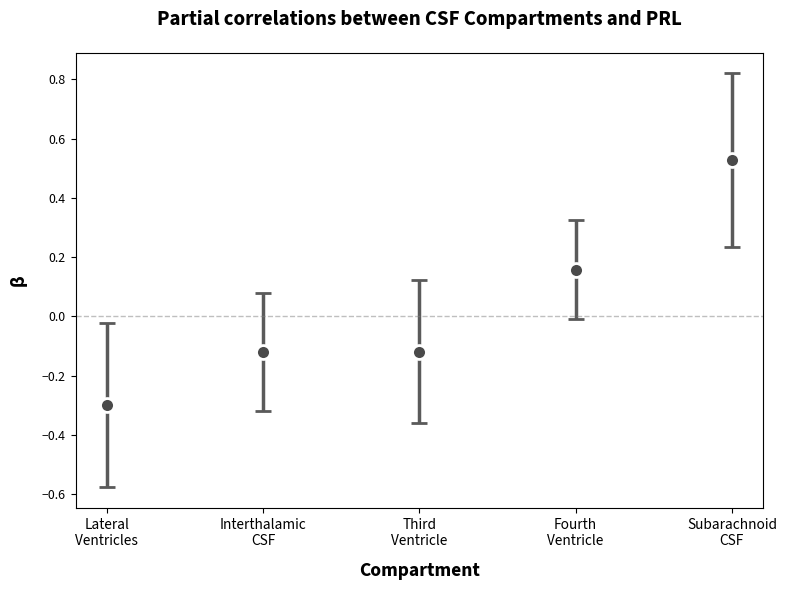

: 

In [ ]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
predictors = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
outcome = "PRL"

test_covariates = {
    "basic": ["age", "Female", "tiv"],
    "CP": ["CP", "age", "Female", "tiv"],
    "T2LV": ["T2LV_log1p", "age", "Female", "tiv"],
    "WBV": ["WBV", "age", "Female", "tiv"],
    "CP+T2LV": ["CP", "T2LV_log1p", "age", "Female", "tiv"],
    "CP+T2LV+WBV": ["CP", "T2LV_log1p", "WBV", "age", "Female", "tiv"],
}
results = {}
for model_name, covariates in test_covariates.items():
    results[model_name], _, _ = regutils.run_regressions(
        model_data, outcome, predictors, covariates=covariates, regression_model="GLM"
    )

control_name = "CP+T2LV"
display_results(
    results[control_name], "PRL", "*predictor*", test_covariates[control_name]
)

control_name = "CP+T2LV+WBV"
result = results[control_name]
covariates = test_covariates[control_name]
display_results(result, "PRL", "*predictor*", covariates)

plot_data = result
fig, ax = plot_betas(
    coefficients=plot_data["coef"],
    lower_ci=plot_data["llci"],
    upper_ci=plot_data["ulci"],
    title="Partial correlations between CSF Compartments and PRL",
    labels=[
        "Lateral\nVentricles",
        "Interthalamic\nCSF",
        "Third\nVentricle",
        "Fourth\nVentricle",
        "Subarachnoid\nCSF",
    ],
    connect_points=False,
    fig_transparent=False,
    axs_transparent=False,
)

#### Sanity check on peripheral CSF

The following is more of a sanity check. If all the CSF volumes are defined properly, particulary peripheral CSF, we'd expect thalamic volume to be related more to the central CSF compartments and for brain volume to be related more to the peripheral CSF volume. This is borne out. Peripheral CSF has a much stronger relationship to WBV and LV has a much stronger relationship to thalamus

In [ ]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])

rename_index = {"WBV": "**WBV**", "THALAMUS_1": "**THALAMUS_1**"}

test_outcomes = ["LV_log", "thirdV_log", "fourthV_log", "periCSF"]
all_results = defaultdict(dict)
all_models = defaultdict(dict)
all_formulas = defaultdict(dict)
for outcome in test_outcomes:
    formula_list = {
        "WBV": f"{outcome} ~ WBV + age + Female + tiv",
        "thalamus": f"{outcome} ~ THALAMUS_1 + age + Female + tiv",
        "WBV+thalamus": f"{outcome} ~ WBV + THALAMUS_1 + age + Female + tiv",
    }

    all_results[outcome], all_models[outcome], all_formulas[outcome] = (
        regutils.run_regressions3(
            model_data_z, formula_list.values(), model_names=formula_list.keys()
        )
    )

views = [("periCSF", "WBV+thalamus"), ("LV_log", "WBV+thalamus")]
for outcome, model_name in views:
    display(Markdown(f"##### {outcome}"))
    results = all_results[outcome]
    formulas = all_formulas[outcome]
    model = results[model_name]
    formula = formulas[model_name]

    display(Markdown(f"{model_name}"))
    display(Markdown(f"`{formula}`"))
    display(
        Markdown(
            regutils.present_model(
                model, presentation_cols, rename_index=rename_index
            ).to_markdown()
            + "\n\n"
        )
    )
note = "*Note: WBV has a significant association with LV_log before controlling for THALAMUS_1*"
display(Markdown(note))

##### periCSF

WBV+thalamus

`periCSF ~ WBV + THALAMUS_1 + age + Female + tiv`

|                |    coef |     pval |     se | ci                |   R2 |
|:---------------|--------:|---------:|-------:|:------------------|-----:|
| Intercept      | -0.1144 | 0.071    | 0.0634 | [-0.239, 0.00989] |  0.7 |
| Female[T.1]    |  0.1459 | 0.052    | 0.0752 | [-0.00151, 0.293] |  0.7 |
| **WBV**        | -1.1718 | 2.9e-35  | 0.0946 | [-1.36, -0.986]   |  0.7 |
| **THALAMUS_1** |  0.2218 | 3e-06    | 0.0475 | [0.129, 0.315]    |  0.7 |
| age            | -0.0565 | 0.069    | 0.031  | [-0.117, 0.00429] |  0.7 |
| tiv            |  1.6771 | 8.6e-104 | 0.0775 | [1.53, 1.83]      |  0.7 |



##### LV_log

WBV+thalamus

`LV_log ~ WBV + THALAMUS_1 + age + Female + tiv`

|                |    coef |    pval |     se | ci               |   R2 |
|:---------------|--------:|--------:|-------:|:-----------------|-----:|
| Intercept      | -0.0604 | 0.38    | 0.0689 | [-0.195, 0.0746] | 0.59 |
| Female[T.1]    |  0.077  | 0.35    | 0.0817 | [-0.0831, 0.237] | 0.59 |
| **WBV**        | -0.8626 | 2.1e-13 | 0.1175 | [-1.09, -0.632]  | 0.59 |
| **THALAMUS_1** | -0.3248 | 1.2e-09 | 0.0534 | [-0.43, -0.22]   | 0.59 |
| age            |  0.0782 | 0.032   | 0.0365 | [0.00672, 0.15]  | 0.59 |
| tiv            |  1.1115 | 2.1e-33 | 0.0923 | [0.931, 1.29]    | 0.59 |



*Note: WBV has a significant association with LV_log before controlling for THALAMUS_1*

: 

### Central CSF Expansion

Does the relationship between CP and LV volumes represent a global process whereby CP influences overall atrophy or CSF hydrodynamics, or is CP causing regional changes? With the degree of preferential central expansion defined as the central CSF ratio (CCR):

$CCR = LV / periCSF$

#### CCR baseline associations with atrophy and inflammation

Worsening of each variable is associated with greater CCR, suggesting that atrophy in general occurs faster in more central locations. 

In [ ]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])

outcomes = ["CCR2_log", "LV_div_thirdV_interCSF_log"]
predictors = ["CP", "T2LV_log1p", "WTV", "WBV", "WMV", "GMV", "cortical_thickness"]
covariates = ["age", "Female", "tiv"]

results, _, models = regutils.run_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

# for predictor, result in results.items():
for outcome in ["CCR2_log"]:
    result = results[outcome]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = predictors
    # display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```R
CCR2_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |   p_fdr |     se | ci               |   R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|
| CP                 |  0.6355 | 6.7e-74 | 0.0347 | [0.567, 0.704]   | 0.51 |
| T2LV_log1p         |  0.4215 | 4.6e-22 | 0.0436 | [0.336, 0.507]   | 0.35 |
| WTV                | -0.6295 | 2.8e-65 | 0.0367 | [-0.701, -0.557] | 0.47 |
| WBV                | -1.2634 | 4e-51   | 0.0837 | [-1.43, -1.1]    | 0.47 |
| WMV                | -0.8923 | 6e-31   | 0.0768 | [-1.04, -0.742]  | 0.36 |
| GMV                | -0.8214 | 4.5e-10 | 0.1317 | [-1.08, -0.563]  | 0.37 |
| cortical_thickness | -0.4595 | 7.4e-28 | 0.0419 | [-0.542, -0.377] | 0.35 |

: 

In [ ]:
model1 = models[("CCR2_log", "CP")]
model2 = models[("CCR2_log", "WBV")]
model3 = models[("CCR2_log", "WTV")]


print("CCR2_log ~ CP + age + Female + tiv")
print(f"R2={model1.rsquared_adj:0.2f}, AIC={model1.aic:0.2f}, BIC={model1.bic:0.2f}")
print("\nCCR2_log ~ WBV + age + Female + tiv")
print(f"R2={model2.rsquared_adj:0.2f}, AIC={model2.aic:0.2f}, BIC={model2.bic:0.2f}")
print("\nCCR2_log ~ WTV + age + Female + tiv")
print(f"R2={model3.rsquared_adj:0.2f}, AIC={model3.aic:0.2f}, BIC={model3.bic:0.2f}")

CCR2_log ~ CP + age + Female + tiv
R2=0.51, AIC=997.93, BIC=1018.67

CCR2_log ~ WBV + age + Female + tiv
R2=0.47, AIC=1038.43, BIC=1059.18

CCR2_log ~ WTV + age + Female + tiv
R2=0.47, AIC=1035.40, BIC=1056.14


: 

#### Does CP predict CCR beyond atrophy?

CP is associated with increasing CCR even after controlling for both WBV and WTV. Compared to the baseline atrophy model, CP actually adds a significant amount of explanatory power, with a ΔR<sup>2</sup> of 0.10. In fact, CP and WTV together capture all the variance in CCR that can be captured by these variables

In [52]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
outcome = "CCR2_log"

exog_list1 = {
    "CT + WTV": ["CT", "WTV"],
    "CP + CT + WTV": ["CP", "CT", "WTV"],
    "WBV": ["WBV"],
}

exog_list_t2lv = {
    "T2LV + CT + WTV": ["T2LV", "CT", "WTV"],
    "CP + T2LV + CT": ["CP", "T2LV_log1p", "CT"],
    "CP + T2LV + WTV": ["CP", "T2LV_log1p", "WTV"],
    "CP + T2LV + CT + WTV": ["CP", "T2LV_log1p", "CT", "WTV"],
    "T2LV + WTV": ["T2LV_log1p", "WTV"],
}

# these are extra models that I don't necessarily need to show but may provide extra context
exog_list2 = {
    "CP": ["CP"],
    "WTV": ["WTV"],
    "CT": ["CT"],
    "CP + WTV": ["CP", "WTV"],
    "CP + CT": ["CP", "CT"],
    "T2LV": ["T2LV_log1p"],
    "CP + T2LV": ["CP", "T2LV_log1p"],
    "CT": ["cortical_thickness"],
}
exog_list3 = {
    "CP + WTV": ["CP", "WTV"],
    "CP + CT": ["CP", "cortical_thickness"],
    "CT + WTV": ["cortical_thickness", "WTV"],
    "CP + CT + WTV": ["CP", "cortical_thickness", "WTV"],
}

covariates = ["age", "Female", "tiv"]

results, models, formulas = regutils.run_regressions_multimodel(
    model_data,
    outcome,
    (exog_list1 | exog_list_t2lv | exog_list2).values(),
    model_names=(exog_list1 | exog_list_t2lv | exog_list2).keys(),
    covariates=covariates,
    robust_cov="HC3",
    to_check_vif=False,
)

show_models = ["CT + WTV", "CP + CT + WTV", "CP + WTV", "CP + CT", "CP", "WTV", "WBV"]
text = ""
for model_name in show_models:
    model = results[model_name]
    formula = formulas[model_name]
    text += f"##### {smart_title(model_name)}\n\n```R\n{formula}\n```\n\n"
    text += regutils.present_model(
        model,
        presentation_cols,
        exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
    ).to_markdown()
    text += "\n\n"

display(Markdown(text))

##### CT + WTV

```R
CCR2_log ~ CT + WTV + age + Female + tiv
```

|     |    coef |   p_fdr |     se | ci                |   R2 |
|:----|--------:|--------:|-------:|:------------------|-----:|
| CT  | -0.1294 | 0.011   | 0.048  | [-0.223, -0.0354] | 0.48 |
| WTV | -0.5451 | 1.6e-26 | 0.0504 | [-0.644, -0.446]  | 0.48 |

##### CP + CT + WTV

```R
CCR2_log ~ CP + CT + WTV + age + Female + tiv
```

|     |    coef |   p_fdr |     se | ci                 |   R2 |
|:----|--------:|--------:|-------:|:-------------------|-----:|
| CP  |  0.4566 | 1.3e-32 | 0.0379 | [0.382, 0.531]     | 0.61 |
| CT  | -0.0881 | 0.028   | 0.04   | [-0.166, -0.00973] | 0.61 |
| WTV | -0.3569 | 4e-13   | 0.0481 | [-0.451, -0.263]   | 0.61 |

##### CP + WTV

```R
CCR2_log ~ CP + WTV + age + Female + tiv
```

|     |    coef |   p_fdr |     se | ci               |   R2 |
|:----|--------:|--------:|-------:|:-----------------|-----:|
| CP  |  0.4623 | 9e-34   | 0.0377 | [0.388, 0.536]   | 0.61 |
| WTV | -0.4115 | 5.3e-22 | 0.0422 | [-0.494, -0.329] | 0.61 |

##### CP + CT

```R
CCR2_log ~ CP + CT + age + Female + tiv
```

|    |    coef |   p_fdr |     se | ci               |   R2 |
|:---|--------:|--------:|-------:|:-----------------|-----:|
| CP |  0.5455 | 3.7e-46 | 0.0379 | [0.471, 0.62]    | 0.56 |
| CT | -0.274  | 6.9e-12 | 0.0391 | [-0.351, -0.197] | 0.56 |

##### CP

```R
CCR2_log ~ CP + age + Female + tiv
```

|    |   coef |   p_fdr |     se | ci             |   R2 |
|:---|-------:|--------:|-------:|:---------------|-----:|
| CP | 0.6343 | 6.4e-74 | 0.0347 | [0.566, 0.702] | 0.51 |

##### WTV

```R
CCR2_log ~ WTV + age + Female + tiv
```

|     |    coef |   p_fdr |     se | ci               |   R2 |
|:----|--------:|--------:|-------:|:-----------------|-----:|
| WTV | -0.6294 | 3.6e-65 | 0.0367 | [-0.701, -0.557] | 0.47 |

##### WBV

```R
CCR2_log ~ WBV + age + Female + tiv
```

|     |    coef |   p_fdr |     se | ci            |   R2 |
|:----|--------:|--------:|-------:|:--------------|-----:|
| WBV | -1.2627 | 9.1e-51 | 0.0837 | [-1.43, -1.1] | 0.47 |



##### F-tests to determine whether CP adds explanatory power beyond atrophy

In [ ]:
all_model_comparisons = [
    ("CT + WTV", "CP + CT + WTV"),
]

model_comparisons = []
for i, model_names in enumerate(all_model_comparisons):
    base_model_name, full_model_name = model_names
    base = models[base_model_name]
    full = models[full_model_name]

    comparison = regutils.compare_models(
        base, full, base_model_name=base_model_name, full_model_name=full_model_name
    )
    comparison.name = i
    model_comparisons.append(comparison)

model_comparisons = pd.concat(model_comparisons, axis=1).T
model_comparisons = model_comparisons.apply(pd.to_numeric, errors="ignore")
display(Markdown(regutils.present_model(model_comparisons).to_markdown()))

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:2274: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  warnings.warn('F test for comparison is likely invalid with ' +


|    | base model   | full model    |    ΔR |   F-statistic |   F-test pval |      LR |   LR pval |   df |
|---:|:-------------|:--------------|------:|--------------:|--------------:|--------:|----------:|-----:|
|  0 | CT + WTV     | CP + CT + WTV | 0.132 |        157.54 |       2.7e-31 | 137.575 |     9e-32 |    1 |

#### T2LV's relationship to CCR

T2LV explains CCR independently of CP when controlling for WBV, but not when controlling for WTV. WTV actually mediates the effect of T2LV on CCR, suggesting that T2LV's contributes to ↑CCR by its effect of Wallerian degeneration

In [ ]:
show_models = [
    "CP + T2LV + WBV",
    "CP + T2LV + WTV",
    "CP + T2LV + WBV + WTV",
    "CP + WBV + WTV",
    "CP + WTV",
]
text = ""
for model_name in show_models:
    model = results[model_name]
    formula = formulas[model_name]
    text += f"##### {smart_title(model_name)}\n\n```R\n{formula}\n```\n\n"
    text += regutils.present_model(
        model,
        presentation_cols,
        exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
    ).to_markdown()
    text += "\n\n"

display(Markdown(text))


##### CP + T2LV + WBV

```R
CCR2_log ~ CP + T2LV_log1p + WBV + age + Female + tiv
```

|            |    coef |   p_fdr |     se | ci              |   R2 |
|:-----------|--------:|--------:|-------:|:----------------|-----:|
| CP         |  0.4256 | 5.9e-23 | 0.04   | [0.347, 0.504]  | 0.59 |
| T2LV_log1p |  0.1613 | 1.3e-05 | 0.0355 | [0.0915, 0.231] | 0.59 |
| WBV        | -0.5889 | 8.1e-10 | 0.0913 | [-0.768, -0.41] | 0.59 |

##### CP + T2LV + WTV

```R
CCR2_log ~ CP + T2LV_log1p + WTV + age + Female + tiv
```

|            |    coef |   p_fdr |     se | ci               |   R2 |
|:-----------|--------:|--------:|-------:|:-----------------|-----:|
| CP         |  0.4584 | 1.5e-30 | 0.0364 | [0.387, 0.53]    | 0.61 |
| T2LV_log1p |  0.0605 | 0.13    | 0.0402 | [-0.0185, 0.139] | 0.61 |
| WTV        | -0.3696 | 1.9e-13 | 0.0476 | [-0.463, -0.276] | 0.61 |

##### CP + T2LV + WBV + WTV

```R
CCR2_log ~ CP + T2LV_log1p + WBV + WTV + age + Female + tiv
```

|            |    coef |   p_fdr |     se | ci                |   R2 |
|:-----------|--------:|--------:|-------:|:------------------|-----:|
| CP         |  0.4217 | 1.8e-23 | 0.0391 | [0.345, 0.498]    | 0.61 |
| T2LV_log1p |  0.0645 | 0.11    | 0.04   | [-0.0141, 0.143]  | 0.61 |
| WBV        | -0.277  | 0.024   | 0.1098 | [-0.493, -0.0612] | 0.61 |
| WTV        | -0.2836 | 6.4e-06 | 0.0583 | [-0.398, -0.169]  | 0.61 |

##### CP + WBV + WTV

```R
CCR2_log ~ CP + WBV + WTV + age + Female + tiv
```

|     |    coef |   p_fdr |     se | ci               |   R2 |
|:----|--------:|--------:|-------:|:-----------------|-----:|
| CP  |  0.4268 | 4.3e-24 | 0.039  | [0.35, 0.503]    | 0.61 |
| WBV | -0.27   | 0.025   | 0.1099 | [-0.486, -0.054] | 0.61 |
| WTV | -0.3304 | 6.4e-10 | 0.0507 | [-0.43, -0.231]  | 0.61 |

##### CP + WTV

```R
CCR2_log ~ CP + WTV + age + Female + tiv
```

|     |    coef |   p_fdr |     se | ci               |   R2 |
|:----|--------:|--------:|-------:|:-----------------|-----:|
| CP  |  0.4623 | 3.9e-31 | 0.0364 | [0.391, 0.534]   | 0.61 |
| WTV | -0.4115 | 2.4e-23 | 0.0386 | [-0.487, -0.336] | 0.61 |



T2LV adds no explanatory power to CCR compared to a model of CP, WBV, and WTV. To be more precise, all of T2LV's effect on CCR is captured by the combination of CP and WTV. That is the simplest model I could find where the addition of T2LV does not improve explanatory power

In [ ]:
all_model_comparisons = [
    ("CP + WBV + WTV", "CP + T2LV + WBV + WTV"),
    ("CP + WTV", "CP + T2LV + WTV"),
    ("WTV", "T2LV + WTV"),
    ("CP", "CP + T2LV"),
    ("CP + WBV", "CP + T2LV + WBV"),
    ("WBV + WTV", "T2LV + WBV + WTV"),
]

model_comparisons = []
for i, model_names in enumerate(all_model_comparisons):
    base_model_name, full_model_name = model_names
    base = models[base_model_name]
    full = models[full_model_name]

    comparison = regutils.compare_models(
        base, full, base_model_name=base_model_name, full_model_name=full_model_name
    )
    comparison.name = i
    model_comparisons.append(comparison)

model_comparisons = pd.concat(model_comparisons, axis=1).T
model_comparisons = model_comparisons.apply(pd.to_numeric, errors="ignore")
display(Markdown(regutils.present_model(model_comparisons).to_markdown()))

|    | base model     | full model            |     ΔR |   F-statistic |   F-test pval |      LR |   LR pval |   df |
|---:|:---------------|:----------------------|-------:|--------------:|--------------:|--------:|----------:|-----:|
|  0 | CP + WBV + WTV | CP + T2LV + WBV + WTV | 0.0013 |        2.5989 |       0.11    |  2.6367 |   0.1     |    1 |
|  1 | CP + WTV       | CP + T2LV + WTV       | 0.0011 |        2.264  |       0.13    |  2.2928 |   0.13    |    1 |
|  2 | WTV            | T2LV + WTV            | 0.0038 |        4.3204 |       0.038   |  4.3562 |   0.037   |    1 |
|  3 | CP             | CP + T2LV             | 0.0461 |       49.3591 |       7.7e-12 | 47.5054 |   5.5e-12 |    1 |
|  4 | CP + WBV       | CP + T2LV + WBV       | 0.0172 |       20.6182 |       7.2e-06 | 20.4767 |   6e-06   |    1 |
|  5 | WBV + WTV      | T2LV + WBV + WTV      | 0.0132 |       13.8876 |       0.00022 | 13.8903 |   0.00019 |    1 |

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = model_data[["CP", "T2LV_log1p", "TIV", "WBV", "age", "Female", "dzdur"]]
X = X.dropna()
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pyperclip.copy(vif_data)
print(vif_data)

     Variable       VIF
0          CP  1.667046
1  T2LV_log1p  1.557044
2         TIV  6.747660
3         WBV  7.407178
4         age  1.839452
5      Female  1.067902
6       dzdur  1.694038


In [250]:
formula = "WTV ~ WBV + CP + age + Female"
vars = formula.split(" + ")
vars[0].split(" ~ ")
vars[1:] + vars[0].split(" ~ ")

['CP', 'age', 'Female', 'WTV', 'WBV']

##### Mediation of T2LV on CCR by WTV

WTV fully mediates the effect of T2LV on expanding CCR when controlling CP. 

In [196]:
p2 = Process(
    data=model_data,
    model=4,
    x="T2LV_log1p",
    y="CCR2_log",
    m=["WBV", "WTV"],
    controls=["CP", "age", "Female", "tiv"],
    controls_in="all",
    suppr_init=True,
)

outcome, mediation = utils.read_pyprocess_output(p2)

with open("mediation_tmp.txt", "w") as f:
    f.write("=" * 80 + "\n")
    f.write(outcome)
    # f.write("\n\n")
    f.write(mediation)
    f.write("\n" + "=" * 80 + "\n")


print("=" * 80)
print(mediation)
print("=" * 80)



Direct effect of T2LV_log1p on CCR2_log:

  Effect     SE      t      p    LLCI   ULCI
  0.0645 0.0400 1.6121 0.1076 -0.0139 0.1429

Indirect effect of T2LV_log1p on CCR2_log:

       Effect  Boot SE  BootLLCI  BootULCI
  WBV  0.0385   0.0190    0.0055    0.0794
  WTV  0.1402   0.0306    0.0814    0.2028




#### CCR and regional thalamic atrophy

##### Partial correlations between CCR, WTV, and nuclei groups

In [6]:
disease_group = "MS"
influenced_var = "CCR2_log"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

# covariates = ["WBV", "age", "Female", "tiv"]
covariates = ["age", "Female", "tiv"]
results = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [7]:
pearson_results, thalamus_comps, nuclei_comps = results
display(
    Markdown(
        f"##### Patients with {disease_group}\n\nAssess {influenced_var} and control for {', '.join(covariates)}"
    )
)

display(
    Markdown(
        f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"
    )
)
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### Patients with MS

Assess CCR2_log and control for age, Female, tiv

**Pearson correlations of residualized thalamic nuclei and CCR2_log:**

```visualprolog
THALAMUS_1: r=-0.588, p=6.01e-45
medial: r=-0.639, p=5.26e-55
posterior: r=-0.583, p=6.90e-44
anterior: r=-0.362, p=6.18e-16
ventral: r=-0.379, p=2.01e-17
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
+ medial > THALAMUS_1: p=3.71e-04
  posterior = THALAMUS_1: p=6.58e-01
- anterior < THALAMUS_1: p=1.42e-12
- ventral < THALAMUS_1: p=2.39e-31
```



**Comparisons between thalamic nuclei:**

```diff
+ medial > posterior: p=3.00e-03
+ medial > anterior: p=2.25e-16
+ medial > ventral: p=1.83e-22
+ posterior > anterior: p=6.43e-11
+ posterior > ventral: p=1.95e-12
  anterior = ventral: p=6.56e-01
```


In [8]:
disease_group = "MS"
influenced_var = "CP"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

covariates = ["age", "Female", "tiv"]
results = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [9]:
pearson_results, thalamus_comps, nuclei_comps = results
display(Markdown(f"##### Patients with {disease_group}"))

display(
    Markdown(
        f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"
    )
)
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### Patients with MS

**Pearson correlations of residualized thalamic nuclei and CP:**

```visualprolog
THALAMUS_1: r=-0.444, p=5.33e-24
medial: r=-0.47, p=3.86e-27
posterior: r=-0.453, p=5.00e-25
anterior: r=-0.258, p=1.55e-08
ventral: r=-0.274, p=1.64e-09
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
  medial = THALAMUS_1: p=9.77e-02
  posterior = THALAMUS_1: p=5.39e-01
- anterior < THALAMUS_1: p=9.75e-08
- ventral < THALAMUS_1: p=1.68e-17
```



**Comparisons between thalamic nuclei:**

```diff
  medial = posterior: p=4.12e-01
+ medial > anterior: p=1.65e-08
+ medial > ventral: p=5.22e-11
+ posterior > anterior: p=9.87e-08
+ posterior > ventral: p=1.25e-08
  anterior = ventral: p=6.79e-01
```


##### CCR and all thalamic + deep grey

In [ ]:
model_data = zscore(data[MS_patients].copy())

outcomes = hips_thomas_ref[thalamic_nuclei + deep_grey]
predictors = ["CCR2_log", "CP", "T2LV_log1p"]
covariates = ["WBV", "age", "Female", "tiv"]

_, results, models = regutils.run_regressions(
    model_data, outcomes, predictors, covariates
)

predictor = "CCR2_log"
result = results[predictor]
formula = regutils.formula_string("thalamic nucleus", f"*{predictor}*", covariates)
display_order = outcomes
sorted_index = result["coef"].sort_values(ascending=True).index
display_order = sorted_index[sorted_index.isin(hips_thomas_ref[thalamic_nuclei])]
display(Markdown(f"```R\n{formula}\n```\n"))
display(
    Markdown(
        regutils.present_model(
            result,
            cols=presentation_cols,
            inds=display_order,
        ).to_markdown()
    )
)
copy1 = regutils.present_model(
    result,
    cols=presentation_cols,
    inds=display_order,
).to_markdown()

formula = regutils.formula_string("deep grey", f"*{predictor}*", covariates)
display(Markdown(f"```R\n{formula}\n```\n"))
display_order = sorted_index[sorted_index.isin(hips_thomas_ref[deep_grey])]
display(
    Markdown(
        regutils.present_model(
            result,
            cols=presentation_cols,
            inds=display_order,
        ).to_markdown()
    )
)
copy2 = regutils.present_model(
    result,
    cols=presentation_cols,
    inds=display_order,
).to_markdown()

```R
thalamic nucleus ~ *CCR2_log* + WBV + age + Female + tiv
```


| outcome   |    coef |   p_fdr |     se | ci                |   R2 |
|:----------|--------:|--------:|-------:|:------------------|-----:|
| MD_Pf_12  | -0.3524 | 1.3e-15 | 0.0422 | [-0.435, -0.27]   | 0.65 |
| LGN_9     | -0.3326 | 1.6e-08 | 0.056  | [-0.442, -0.223]  | 0.44 |
| Pul_8     | -0.275  | 7.7e-09 | 0.0448 | [-0.363, -0.187]  | 0.59 |
| MGN_10    | -0.2497 | 9.6e-08 | 0.0448 | [-0.338, -0.162]  | 0.57 |
| CM_11     | -0.1724 | 0.00047 | 0.0459 | [-0.262, -0.0825] | 0.53 |
| AV_2      | -0.1257 | 0.026   | 0.0508 | [-0.225, -0.026]  | 0.41 |
| VLP_6     | -0.0512 | 0.32    | 0.0461 | [-0.142, 0.0391]  | 0.56 |
| VPL_7     | -0.0458 | 0.36    | 0.0484 | [-0.141, 0.0491]  | 0.49 |
| VA_4      |  0.0622 | 0.24    | 0.0434 | [-0.0229, 0.147]  | 0.54 |
| VLa_5     |  0.0658 | 0.25    | 0.0503 | [-0.0327, 0.164]  | 0.48 |

```R
deep grey ~ *CCR2_log* + WBV + age + Female + tiv
```


| outcome   |    coef |   p_fdr |     se | ci                |   R2 |
|:----------|--------:|--------:|-------:|:------------------|-----:|
| Acc_26    | -0.2553 | 1.6e-08 | 0.0432 | [-0.34, -0.171]   | 0.59 |
| Cla_28    | -0.2165 | 2.9e-06 | 0.0441 | [-0.303, -0.13]   | 0.6  |
| Hb_13     | -0.1517 | 0.028   | 0.063  | [-0.275, -0.0282] | 0.17 |
| Put_31    | -0.1337 | 0.013   | 0.0479 | [-0.228, -0.0397] | 0.52 |
| RN_32     | -0.0594 | 0.25    | 0.0464 | [-0.15, 0.0316]   | 0.54 |
| Cau_27    | -0.0122 | 0.78    | 0.0435 | [-0.0974, 0.073]  | 0.4  |
| GPe_29    |  0.0505 | 0.36    | 0.053  | [-0.0533, 0.154]  | 0.39 |
| GPi_30    |  0.0704 | 0.25    | 0.0539 | [-0.0354, 0.176]  | 0.31 |
| MTT_14    |  0.1639 | 0.017   | 0.0619 | [0.0425, 0.285]   | 0.31 |

In [ ]:
model_data = zscore(data[MS_patients].copy())

outcomes = hips_thomas_ref[thalamic_nuclei + deep_grey].to_list()
predictors = ["CCR2_log", "CP", "T2LV_log1p"]
covariates = ["WBV", "age", "Female", "tiv"]

_, results, models = regutils.run_partial_regressions(
    model_data, outcomes, predictors, covariates, corr_type="pearson"
)

predictor = "CCR2_log"
result = results[predictor]
formula = regutils.formula_string("thalamic nucleus", f"*{predictor}*", covariates)
display_order = outcomes
sorted_index = result["coef"].sort_values(ascending=True).index
display_order = sorted_index[sorted_index.isin(hips_thomas_ref[thalamic_nuclei])]
display(Markdown(f"```R\n{formula}\n```\n"))
display(
    Markdown(
        regutils.present_model(
            result,
            cols=presentation_cols,
            inds=display_order,
        ).to_markdown()
    )
)
copy1 = regutils.present_model(
    result,
    cols=presentation_cols,
    inds=display_order,
).to_markdown()

formula = regutils.formula_string("deep grey", f"*{predictor}*", covariates)
display(Markdown(f"```R\n{formula}\n```\n"))
display_order = sorted_index[sorted_index.isin(hips_thomas_ref[deep_grey])]
display(
    Markdown(
        regutils.present_model(
            result,
            cols=presentation_cols,
            inds=display_order,
        ).to_markdown()
    )
)
copy2 = regutils.present_model(
    result,
    cols=presentation_cols,
    inds=display_order,
).to_markdown()

```R
thalamic nucleus ~ *CCR2_log* + WBV + age + Female + tiv
```


| outcome   |    coef |   p_fdr | ci             |
|:----------|--------:|--------:|:---------------|
| MD_Pf_12  | -0.3967 | 8.3e-18 | [-0.47, -0.32] |
| LGN_9     | -0.3085 | 8.5e-11 | [-0.39, -0.22] |
| Pul_8     | -0.2987 | 2.7e-10 | [-0.38, -0.21] |
| MGN_10    | -0.2677 | 1.5e-08 | [-0.35, -0.18] |
| CM_11     | -0.1814 | 0.00021 | [-0.27, -0.09] |
| AV_2      | -0.1184 | 0.018   | [-0.21, -0.03] |
| VLP_6     | -0.0563 | 0.27    | [-0.15, 0.03]  |
| VPL_7     | -0.0466 | 0.33    | [-0.14, 0.04]  |
| VLa_5     |  0.0664 | 0.22    | [-0.02, 0.16]  |
| VA_4      |  0.0667 | 0.22    | [-0.02, 0.16]  |

```R
deep grey ~ *CCR2_log* + WBV + age + Female + tiv
```


| outcome   |    coef |   p_fdr | ci             |
|:----------|--------:|--------:|:---------------|
| Acc_26    | -0.2797 | 3.5e-09 | [-0.36, -0.19] |
| Cla_28    | -0.2411 | 4.1e-07 | [-0.32, -0.15] |
| Put_31    | -0.1393 | 0.0053  | [-0.23, -0.05] |
| Hb_13     | -0.1209 | 0.017   | [-0.21, -0.03] |
| RN_32     | -0.0638 | 0.23    | [-0.15, 0.03]  |
| Cau_27    | -0.0115 | 0.8     | [-0.1, 0.08]   |
| GPe_29    |  0.0472 | 0.33    | [-0.04, 0.14]  |
| GPi_30    |  0.0616 | 0.23    | [-0.03, 0.15]  |
| MTT_14    |  0.1424 | 0.0048  | [0.05, 0.23]   |

In [151]:
pyperclip.copy(copy2)
# pyperclip.copy(copy2)

#### Other check

If I define another ratio of `LV / (thirdV + interCSF)`, I actually see the coefficient for WBV flip once CP and WTV are controlled.

In [ ]:
# Check LV / (thirdV + interCSF)

### Partial Correlations

In [186]:
work_data = zscore(data[MS_patients].copy())
csf_vars = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain"]
all_vars = csf_vars + predictors
resid_data = work_data[all_vars].copy()
covariates = ["WBV", "age", "Female", "tiv"]

for var in all_vars:
    resid_data[var] = utils.residualize_structs(work_data, var, covariates)

# resid_data = resid_data.dropna()
resid_data_z = zscore(resid_data)

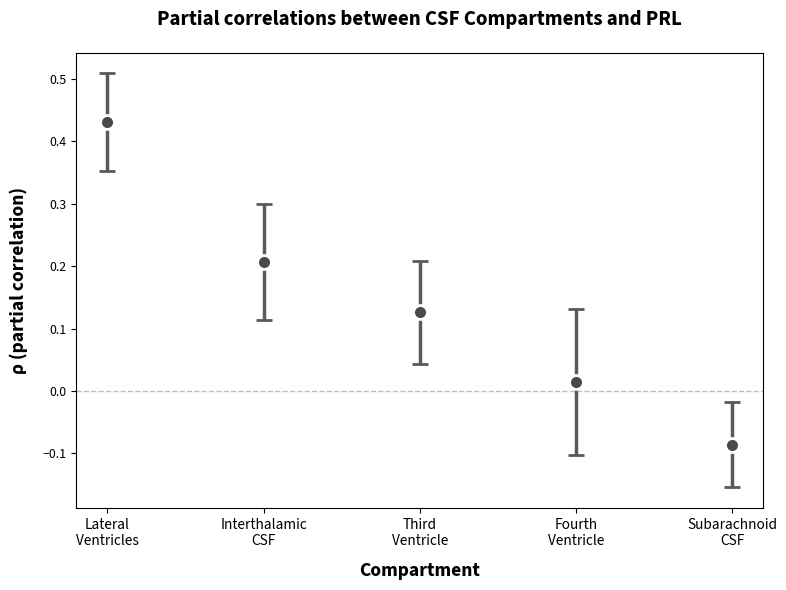

In [ ]:
model_data = resid_data

csf_compartments = [
    "LV_log",
    "interCSF_log",
    "thirdV_log",
    "fourthV_log",
    "periCSF_log",
]
predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain"]
covariates = None

_, results, check = regutils.run_regressions(
    model_data, csf_compartments, predictors, covariates=covariates
)

plot_data = results["CP"]
fig, ax = plot_betas(
    coefficients=plot_data["coef"],
    lower_ci=plot_data["llci"],
    upper_ci=plot_data["ulci"],
    title="Partial correlations between CSF Compartments and PRL",
    labels=[
        "Lateral\nVentricles",
        "Interthalamic\nCSF",
        "Third\nVentricle",
        "Fourth\nVentricle",
        "Subarachnoid\nCSF",
    ],
    connect_points=False,
    fig_transparent=False,
    axs_transparent=False,
)

### Unstandardized Regressions

To get a sense of the scale of each compartment

In [ ]:
compartments_raw = ["LV", "interCSF", "thirdV", "fourthV", "periCSF"]
compartments_log = [
    "LV_log",
    "interCSF_log",
    "thirdV_log",
    "fourthV_log",
    "periCSF_log",
]
model_data = zscore(data[MS_patients], skip_vars=compartments_raw + compartments_log)

max_width = max(len(outcome) for outcome in compartments_raw + compartments_log)

print("Raw volumes:")
for outcome in compartments_raw:
    print(
        f"{outcome:<{max_width + 1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}"
    )

print("\nLog volumes:")
for outcome in compartments_log:
    print(
        f"{outcome:<{max_width + 1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}"
    )

Raw volumes:
LV           : 19454.91 ± 14852.40
interCSF     : 963.13 ± 347.66
thirdV       : 954.28 ± 483.20
fourthV      : 1747.36 ± 511.06
periCSF      : 344944.62 ± 34932.04

Log volumes:
LV_log       : 9.64 ± 0.69
interCSF_log : 6.81 ± 0.36
thirdV_log   : 6.74 ± 0.48
fourthV_log  : 7.43 ± 0.28
periCSF_log  : 12.75 ± 0.10


In [ ]:
central_vars = ["CCR", "CCR2", "CCR_norm", "CCR2_norm", "CCR2_norm2"]
central_vars_log = [var + "_log" for var in central_vars]
model_data = zscore(data[MS_patients], skip_vars=central_vars + central_vars_log)

max_width = max(len(outcome) for outcome in central_vars + central_vars_log)

print("Raw volumes:")
for outcome in central_vars:
    print(
        f"{outcome:<{max_width + 1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}"
    )

print("\nLog volumes:")
for outcome in central_vars_log:
    print(
        f"{outcome:<{max_width + 1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}"
    )

Raw volumes:
CCR            : 0.06 ± 0.04
CCR2           : 0.06 ± 0.04
CCR_norm       : 1.02 ± 0.77
CCR2_norm      : 1.02 ± 0.75
CCR2_norm2     : 2.03 ± 1.19

Log volumes:
CCR_log        : -3.11 ± 0.67
CCR2_log       : -3.05 ± 0.65
CCR_norm_log   : -0.21 ± 0.67
CCR2_norm_log  : -0.20 ± 0.65
CCR2_norm2_log : 0.57 ± 0.52


In [ ]:
compartments_raw = ["LV", "interCSF", "thirdV", "fourthV", "periCSF"]
compartments_log = [
    "LV_log",
    "interCSF_log",
    "thirdV_log",
    "fourthV_log",
    "periCSF_log",
]
model_data = zscore(data[MS_patients], skip_vars=compartments_raw + compartments_log)

max_width = max(len(outcome) for outcome in compartments_raw + compartments_log)
display_text = ""
display_text += f"{p}<u>Raw volumes:</u></p>"


display_volumes = [
    f"{outcome:<{max_width + 1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}"
    for outcome in compartments_raw
]
display_text += f"{p}{'<br>'.join(display_volumes)}</p>"
# display(HTML(display_text))

# display_text = ""
display_text += f"{p}<u>Transformed volumes:</u></p>"
display_volumes = [
    f"{outcome:<{max_width + 1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}"
    for outcome in compartments_log
]
display_text += f"{p}{'<br>'.join(display_volumes)}</p>"
display(HTML(display_text))

Outcomes are raw values and predictors are Z-scored. Betas represent the change in mm3 of the compartment with 1SD change in the predictor

In [ ]:
outcomes = compartments_raw
model_data = zscore(data[MS_patients], skip_vars=outcomes)

predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain", "cortical_thickness"]
covariates = ["age", "Female", "tiv"]

results, _, check = regutils.run_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

outcome_volumes = [
    f"{model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}"
    for outcome in compartments_raw
]

# for predictor, result in results.items():
for i, outcome in enumerate(outcomes):
    result = results[outcome]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = predictors
    display(Markdown(f"```log\n{outcome} Mean: {outcome_volumes[i]}\n```\n"))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```log
LV Mean: 19492.70 ± 14859.00
```


```R
LV ~ *predictor* + age + Female + tiv
```


| predictor          |      coef |   p_fdr |       se | ci                     |   R2 |
|:-------------------|----------:|--------:|---------:|:-----------------------|-----:|
| CP                 |   6666.82 | 1.6e-31 |  567.059 | [5.56e+03, 7.78e+03]   | 0.37 |
| t2lv_log           |   5566.21 | 3.7e-11 |  841.397 | [3.92e+03, 7.22e+03]   | 0.33 |
| THALAMUS_1         |  -9449.65 | 3.8e-40 |  706.051 | [-1.08e+04, -8.07e+03] | 0.49 |
| brain              | -16883.3  | 1.8e-13 | 2283.94  | [-2.14e+04, -1.24e+04] | 0.33 |
| cortical_thickness |  -7251.02 | 1.4e-19 |  796.084 | [-8.81e+03, -5.69e+03] | 0.39 |

```log
interCSF Mean: 964.45 ± 348.45
```


```R
interCSF ~ *predictor* + age + Female + tiv
```


| predictor          |     coef |   p_fdr |      se | ci                     |   R2 |
|:-------------------|---------:|--------:|--------:|:-----------------------|-----:|
| CP                 |  150.587 | 1.1e-22 | 15.219  | [1.21e+02, 1.8e+02]    | 0.25 |
| t2lv_log           |  105.765 | 2.1e-06 | 22.2847 | [62.1, 1.49e+02]       | 0.18 |
| THALAMUS_1         | -202.174 | 2.1e-32 | 16.8671 | [-2.35e+02, -1.69e+02] | 0.34 |
| brain              | -431.114 | 2.2e-20 | 46.3175 | [-5.22e+02, -3.4e+02]  | 0.24 |
| cortical_thickness | -156.704 | 7.3e-17 | 18.7257 | [-1.93e+02, -1.2e+02]  | 0.25 |

```log
thirdV Mean: 955.76 ± 483.74
```


```R
thirdV ~ *predictor* + age + Female + tiv
```


| predictor          |     coef |   p_fdr |      se | ci                     |   R2 |
|:-------------------|---------:|--------:|--------:|:-----------------------|-----:|
| CP                 |  176.9   | 3.6e-18 | 20.1136 | [1.37e+02, 2.16e+02]   | 0.32 |
| t2lv_log           |  163.38  | 5.4e-09 | 28.0096 | [1.08e+02, 2.18e+02]   | 0.32 |
| THALAMUS_1         | -289.863 | 2.8e-45 | 20.3622 | [-3.3e+02, -2.5e+02]   | 0.47 |
| brain              | -541.141 | 2.2e-16 | 65.6896 | [-6.7e+02, -4.12e+02]  | 0.34 |
| cortical_thickness | -221.976 | 1e-17   | 25.7135 | [-2.72e+02, -1.72e+02] | 0.38 |

```log
fourthV Mean: 1749.45 ± 512.52
```


```R
fourthV ~ *predictor* + age + Female + tiv
```


| predictor          |      coef |   p_fdr |      se | ci                     |   R2 |
|:-------------------|----------:|--------:|--------:|:-----------------------|-----:|
| CP                 |  114.646  | 1.5e-05 | 25.7823 | [64.1, 1.65e+02]       | 0.14 |
| t2lv_log           |   76.3952 | 0.0042  | 26.6602 | [24.1, 1.29e+02]       | 0.12 |
| THALAMUS_1         | -137.983  | 2.9e-06 | 28.3918 | [-1.94e+02, -82.3]     | 0.16 |
| brain              | -401.058  | 1.7e-06 | 78.6161 | [-5.55e+02, -2.47e+02] | 0.16 |
| cortical_thickness | -124.168  | 1.6e-05 | 28.4583 | [-1.8e+02, -68.4]      | 0.15 |

```log
periCSF Mean: 345018.14 ± 34930.85
```


```R
periCSF ~ *predictor* + age + Female + tiv
```


| predictor          |      coef |   p_fdr |      se | ci                     |   R2 |
|:-------------------|----------:|--------:|--------:|:-----------------------|-----:|
| CP                 |   5204.57 | 2.7e-05 | 1224.08 | [2.81e+03, 7.6e+03]    | 0.58 |
| t2lv_log           |   1671.48 | 0.2     | 1305.53 | [-8.87e+02, 4.23e+03]  | 0.56 |
| THALAMUS_1         |  -7081.38 | 4e-06   | 1502.19 | [-1e+04, -4.14e+03]    | 0.59 |
| brain              | -49197.5  | 6e-64   | 2897.82 | [-5.49e+04, -4.35e+04] | 0.75 |
| cortical_thickness | -10687.1  | 5.2e-10 | 1681.39 | [-1.4e+04, -7.39e+03]  | 0.63 |

Predictors are Z-scored but the outcomes are just log transformed. 

In [ ]:
outcomes = compartments_log
model_data = zscore(data[MS_patients], skip_vars=outcomes)

predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain", "cortical_thickness"]
covariates = ["age", "Female", "tiv"]

results, _, check = regutils.run_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

outcome_volumes = [
    f"{model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}"
    for outcome in compartments_log
]

# for predictor, result in results.items():
for i, outcome in enumerate(outcomes):
    result = results[outcome]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = predictors
    display(Markdown(f"```log\n{outcome} Mean: {outcome_volumes[i]}\n```\n"))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```log
LV_log Mean: 9.64 ± 0.69
```


```R
LV_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |   p_fdr |     se | ci               |   R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|
| CP                 |  0.4421 | 2.9e-84 | 0.0226 | [0.398, 0.486]   | 0.57 |
| t2lv_log           |  0.2738 | 2.3e-13 | 0.0374 | [0.201, 0.347]   | 0.38 |
| THALAMUS_1         | -0.4374 | 2.6e-76 | 0.0236 | [-0.484, -0.391] | 0.53 |
| brain              | -0.7154 | 1e-16   | 0.0859 | [-0.884, -0.547] | 0.34 |
| cortical_thickness | -0.3364 | 2.7e-33 | 0.0279 | [-0.391, -0.282] | 0.42 |

```log
interCSF_log Mean: 6.81 ± 0.36
```


```R
interCSF_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |   p_fdr |     se | ci               |   R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|
| CP                 |  0.168  | 2.2e-25 | 0.016  | [0.137, 0.199]   | 0.27 |
| t2lv_log           |  0.1011 | 1.2e-05 | 0.0231 | [0.0558, 0.146]  | 0.17 |
| THALAMUS_1         | -0.2017 | 5.8e-41 | 0.0149 | [-0.231, -0.172] | 0.32 |
| brain              | -0.4379 | 5.8e-21 | 0.0464 | [-0.529, -0.347] | 0.24 |
| cortical_thickness | -0.1536 | 1.2e-19 | 0.0169 | [-0.187, -0.121] | 0.23 |

```log
thirdV_log Mean: 6.74 ± 0.49
```


```R
thirdV_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |   p_fdr |     se | ci               |   R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|
| CP                 |  0.206  | 2.1e-23 | 0.0205 | [0.166, 0.246]   | 0.35 |
| t2lv_log           |  0.1605 | 7e-09   | 0.0277 | [0.106, 0.215]   | 0.31 |
| THALAMUS_1         | -0.2837 | 1.4e-60 | 0.0172 | [-0.317, -0.25]  | 0.45 |
| brain              | -0.5334 | 9.4e-21 | 0.0569 | [-0.645, -0.422] | 0.32 |
| cortical_thickness | -0.2214 | 1.2e-21 | 0.023  | [-0.267, -0.176] | 0.37 |

```log
fourthV_log Mean: 7.43 ± 0.28
```


```R
fourthV_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |   p_fdr |     se | ci                |   R2 |
|:-------------------|--------:|--------:|-------:|:------------------|-----:|
| CP                 |  0.0628 | 9.2e-06 | 0.0138 | [0.0357, 0.0899]  | 0.14 |
| t2lv_log           |  0.0427 | 0.0022  | 0.0139 | [0.0154, 0.07]    | 0.12 |
| THALAMUS_1         | -0.0724 | 3.5e-06 | 0.015  | [-0.102, -0.043]  | 0.15 |
| brain              | -0.216  | 5.2e-07 | 0.0406 | [-0.296, -0.136]  | 0.16 |
| cortical_thickness | -0.0657 | 2.6e-05 | 0.0155 | [-0.096, -0.0354] | 0.15 |

```log
periCSF_log Mean: 12.75 ± 0.10
```


```R
periCSF_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |   p_fdr |     se | ci                 |   R2 |
|:-------------------|--------:|--------:|-------:|:-------------------|-----:|
| CP                 |  0.0156 | 2.1e-05 | 0.0036 | [0.00848, 0.0227]  | 0.57 |
| t2lv_log           |  0.0041 | 0.28    | 0.0038 | [-0.00341, 0.0117] | 0.56 |
| THALAMUS_1         | -0.0198 | 9.2e-06 | 0.0044 | [-0.0283, -0.0113] | 0.58 |
| brain              | -0.1421 | 4.2e-60 | 0.0086 | [-0.159, -0.125]   | 0.74 |
| cortical_thickness | -0.0311 | 5.8e-10 | 0.0049 | [-0.0407, -0.0215] | 0.62 |

In [ ]:
outcomes = compartments_log
model_data = zscore(data[MS_patients], skip_vars=outcomes)

predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain", "cortical_thickness"]
covariates = ["age", "Female", "tiv", "periCSF"]

results, _, check = regutils.run_partial_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

outcome_volumes = [
    f"{model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}"
    for outcome in compartments_log
]

# for predictor, result in results.items():
for i, outcome in enumerate(outcomes):
    result = results[outcome]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = predictors
    display(Markdown(f"```log\n{outcome} Mean: {outcome_volumes[i]}\n```\n"))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```log
LV_log Mean: 9.64 ± 0.69
```


```R
LV_log ~ *predictor* + age + Female + tiv + periCSF
```


| predictor          |    coef |   p_fdr |     se | ci               |   R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|
| CP                 |  0.6681 | 1.2e-82 | 0.0345 | [0.6, 0.736]     | 0.45 |
| t2lv_log           |  0.4353 | 1.5e-13 | 0.059  | [0.32, 0.551]    | 0.19 |
| THALAMUS_1         | -0.629  | 1.4e-78 | 0.0334 | [-0.695, -0.563] | 0.39 |
| brain              | -0.4601 | 1e-24   | 0.0447 | [-0.548, -0.372] | 0.21 |
| cortical_thickness | -0.5236 | 4.3e-30 | 0.0458 | [-0.613, -0.434] | 0.27 |

```log
interCSF_log Mean: 6.81 ± 0.36
```


```R
interCSF_log ~ *predictor* + age + Female + tiv + periCSF
```


| predictor          |    coef |   p_fdr |     se | ci               |    R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|------:|
| CP                 |  0.4079 | 1.2e-21 | 0.0422 | [0.325, 0.491]   | 0.16  |
| t2lv_log           |  0.2731 | 1.6e-05 | 0.0632 | [0.149, 0.397]   | 0.073 |
| THALAMUS_1         | -0.4595 | 2.6e-32 | 0.0384 | [-0.535, -0.384] | 0.21  |
| brain              | -0.3091 | 1.1e-12 | 0.0433 | [-0.394, -0.224] | 0.094 |
| cortical_thickness | -0.326  | 8.2e-13 | 0.0451 | [-0.414, -0.238] | 0.1   |

```log
thirdV_log Mean: 6.74 ± 0.49
```


```R
thirdV_log ~ *predictor* + age + Female + tiv + periCSF
```


| predictor          |    coef |   p_fdr |     se | ci               |   R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|
| CP                 |  0.4051 | 1.3e-20 | 0.0431 | [0.321, 0.49]    | 0.16 |
| t2lv_log           |  0.3489 | 1.2e-08 | 0.0611 | [0.229, 0.469]   | 0.12 |
| THALAMUS_1         | -0.5332 | 1e-53   | 0.0343 | [-0.6, -0.466]   | 0.28 |
| brain              | -0.3491 | 3e-15   | 0.0441 | [-0.436, -0.263] | 0.12 |
| cortical_thickness | -0.4159 | 3e-16   | 0.0505 | [-0.515, -0.317] | 0.17 |

```log
fourthV_log Mean: 7.43 ± 0.28
```


```R
fourthV_log ~ *predictor* + age + Female + tiv + periCSF
```


| predictor          |    coef |   p_fdr |     se | ci                |    R2 |
|:-------------------|--------:|--------:|-------:|:------------------|------:|
| CP                 |  0.187  | 0.00023 | 0.0478 | [0.0933, 0.281]   | 0.033 |
| t2lv_log           |  0.1466 | 0.0041  | 0.0511 | [0.0465, 0.247]   | 0.019 |
| THALAMUS_1         | -0.1987 | 0.00017 | 0.048  | [-0.293, -0.105]  | 0.037 |
| brain              | -0.1903 | 0.00025 | 0.0502 | [-0.289, -0.0918] | 0.034 |
| cortical_thickness | -0.1669 | 0.0012  | 0.0506 | [-0.266, -0.0678] | 0.026 |

```log
periCSF_log Mean: 12.75 ± 0.10
```


```R
periCSF_log ~ *predictor* + age + Female + tiv + periCSF
```


| predictor          |    coef |   p_fdr |     se | ci                 |      R2 |
|:-------------------|--------:|--------:|-------:|:-------------------|--------:|
| CP                 |  0.0418 |    0.44 | 0.045  | [-0.0463, 0.13]    | -0.0004 |
| t2lv_log           | -0.0962 |    0.1  | 0.0469 | [-0.188, -0.00436] |  0.0071 |
| THALAMUS_1         |  0.1071 |    0.1  | 0.0481 | [0.0128, 0.201]    |  0.0093 |
| brain              |  0.0981 |    0.19 | 0.0617 | [-0.0229, 0.219]   |  0.0075 |
| cortical_thickness |  0.0249 |    0.63 | 0.0519 | [-0.0769, 0.127]   | -0.0015 |

---

## PRL Analysis

PRL count is predicted most strongly by the peripheral CSF volume. This variable has an even stronger association with PRL than CP and T2LV.

#### CSF compartment volumes predict PRL count

In [207]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
predictors = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
outcome = "PRL"

test_covariates = {
    "basic": ["age", "Female", "tiv"],
    "CP": ["CP", "age", "Female", "tiv"],
    "T2LV": ["T2LV_log1p", "age", "Female", "tiv"],
    "CP, T2LV": ["CP", "T2LV_log1p", "age", "Female", "tiv"],
}
results = {}
for model_name, covariates in test_covariates.items():
    results[model_name], _, _ = regutils.run_regressions(
        model_data, outcome, predictors, covariates=covariates, regression_model="GLM"
    )

# views = test_covariates.keys() #* all views
views = ["T2LV", "CP", "CP, T2LV"]
for name in views:
    result = results[name]
    covariates = test_covariates[name]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```R
PRL ~ *predictor* + T2LV_log1p + age + Female + tiv
```


| predictor    |    coef |   p_fdr |     se | ci              |   R2 |
|:-------------|--------:|--------:|-------:|:----------------|-----:|
| periCSF_log  |  0.4515 |  0.0011 | 0.1225 | [0.211, 0.692]  | 0.55 |
| fourthV_log  |  0.1779 |  0.074  | 0.0817 | [0.0177, 0.338] | 0.52 |
| LV_log       | -0.0438 |  0.97   | 0.1091 | [-0.258, 0.17]  | 0.51 |
| interCSF_log | -0.0248 |  0.97   | 0.0925 | [-0.206, 0.157] | 0.51 |
| thirdV_log   | -0.0039 |  0.97   | 0.1079 | [-0.215, 0.208] | 0.51 |

```R
PRL ~ *predictor* + CP + age + Female + tiv
```


| predictor    |   coef |   p_fdr |     se | ci              |   R2 |
|:-------------|-------:|--------:|-------:|:----------------|-----:|
| periCSF_log  | 0.4004 |   0.01  | 0.1298 | [0.146, 0.655]  | 0.36 |
| thirdV_log   | 0.2806 |   0.013 | 0.1007 | [0.0832, 0.478] | 0.35 |
| fourthV_log  | 0.2142 |   0.013 | 0.0805 | [0.0563, 0.372] | 0.34 |
| LV_log       | 0.1978 |   0.096 | 0.1187 | [-0.0348, 0.43] | 0.33 |
| interCSF_log | 0.1855 |   0.036 | 0.085  | [0.0189, 0.352] | 0.33 |

```R
PRL ~ *predictor* + CP + T2LV_log1p + age + Female + tiv
```


| predictor    |    coef |   p_fdr |     se | ci               |   R2 |
|:-------------|--------:|--------:|-------:|:-----------------|-----:|
| periCSF_log  |  0.4323 |  0.0025 | 0.1243 | [0.189, 0.676]   | 0.55 |
| LV_log       | -0.2231 |  0.13   | 0.1253 | [-0.469, 0.0225] | 0.52 |
| fourthV_log  |  0.1612 |  0.11   | 0.0806 | [0.00323, 0.319] | 0.53 |
| interCSF_log | -0.0782 |  0.51   | 0.0945 | [-0.263, 0.107]  | 0.52 |
| thirdV_log   | -0.0605 |  0.59   | 0.1114 | [-0.279, 0.158]  | 0.52 |

##### Plot the betas of CSF compartments wrt to PRL

Text(0.0, 1.0, 'Control CP and T2LV')

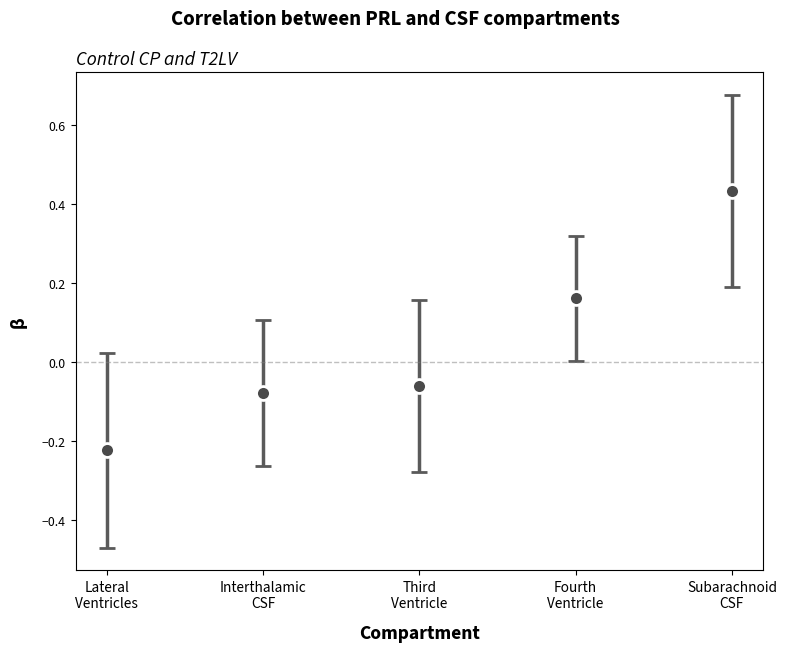

In [ ]:
plot_data = results["CP, T2LV"]
fig, ax = plot_betas(
    coefficients=plot_data["coef"],
    lower_ci=plot_data["llci"],
    upper_ci=plot_data["ulci"],
    title=None,
    labels=[
        "Lateral\nVentricles",
        "Interthalamic\nCSF",
        "Third\nVentricle",
        "Fourth\nVentricle",
        "Subarachnoid\nCSF",
    ],
    connect_points=False,
    fig_transparent=False,
    axs_transparent=False,
)

title = "Correlation between PRL and CSF compartments"
fig.suptitle(
    title, fontsize=15, fontweight="bold", y=1.08
)  # Adjust y position if needed
ax.set_title("Control CP and T2LV", fontsize=14, fontstyle="italic", loc="left")


In [ ]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
predictors = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
outcome = "PRL"

test_covariates = {
    "basic": ["age", "Female", "tiv"],
    "add CP": ["CP", "age", "Female", "tiv"],
    "add CP and t2lv": ["CP", "t2lv_log", "age", "Female", "tiv"],
}

regression_models = {predictor: "OLS" for predictor in predictors}
regression_models["PRL"] = "GLM"

results = {}
for model_name, covariates in test_covariates.items():
    results[model_name], _, _ = regutils.run_partial_regressions(
        model_data,
        outcome,
        predictors,
        covariates=covariates,
        regression_models=regression_models,
        corr_type="pearson",
    )

# views = test_covariates.keys() #* all views
views = ["add CP and t2lv"]
for name in views:
    result = results[name]
    covariates = test_covariates[name]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols_both_ps, inds=display_order
            ).to_markdown()
        )
    )

```R
PRL ~ *predictor* + CP + t2lv_log + age + Female + tiv
```


| predictor    |   coef |   pval |   p_fdr | ci            |
|:-------------|-------:|-------:|--------:|:--------------|
| periCSF_log  | 0.1292 | 0.0051 |   0.026 | [0.04, 0.22]  |
| fourthV_log  | 0.0978 | 0.034  |   0.086 | [0.01, 0.19]  |
| thirdV_log   | 0.0692 | 0.13   |   0.22  | [-0.02, 0.16] |
| interCSF_log | 0.0521 | 0.26   |   0.33  | [-0.04, 0.14] |
| LV_log       | 0.0121 | 0.79   |   0.79  | [-0.08, 0.1]  |

##### Explore some more models for PRL count

In [ ]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])

model_formulas = {
    "CP,t2lv,LV": "PRL ~ LV_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,interCSF": "PRL ~ interCSF_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,thirdV": "PRL ~ thirdV_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,fourthV": "PRL ~ fourthV_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,periCSF": "PRL ~ periCSF_log + CP + t2lv_log + age + Female + tiv",
    "periCSF": "PRL ~ periCSF_log + age + Female + tiv",
    "CP": "PRL ~ CP + age + Female + tiv",
    "t2lv": "PRL ~ t2lv_log + age + Female + tiv",
}

results, models, formulas = regutils.run_regressions3(
    model_data,
    model_formulas.values(),
    model_names=model_formulas.keys(),
    regression_model="GLM",
    family=sm.families.Poisson(),
)

for formula, result in zip(formulas.values(), results.values()):
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"]
            ).to_markdown()
        )
    )

## Analysis around MS Status

### CCR increases in MS

Is CCR specific for MS pathology? Logistic regression of MS status on CCR, controlling for age, sex, and tiv. CCR is increased in MS patients

In [183]:
model_data = data.copy()[(MS_patients) | (NONMS_patients)]
model_data_z = zscore(model_data)
model_data_z = model_data_z.join([pd.get_dummies(model_data["dz_type2"], dtype=int)])

outcome = "MS"  # LV / allCSF
covariates = ["age", "Female", "tiv"]

predictors = {
    "CP": ["CP"],
    "LV_log": ["LV_log"],
    "CCR2_log": ["CCR_log"],
    "periCSF": ["periCSF"],
    "periCSF_ratio_log": ["periCSF_ratio_log"],
}


results, models, formulas = regutils.run_regressions_multimodel(
    model_data_z,
    outcome,
    predictors.values(),
    model_names=predictors.keys(),
    covariates=covariates,
    regression_model="Logit",
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {model_name}"))
    display(Markdown(f"`{formula}`"))
    display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))


# model_name = predictors[0]
# model = results[model_name]
# formula = formulas[model_name]

# display(Markdown(f"#### {model_name}"))
# display(Markdown(f"`{formula}`"))
# display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))


#### CP

`MS ~ CP + age + Female + tiv`

|             |    coef |   p_fdr |     se | ci                 |
|:------------|--------:|--------:|-------:|:-------------------|
| Intercept   |  2.193  | 5.1e-11 | 0.3223 | [1.56, 2.82]       |
| Female[T.1] | -0.6504 | 0.084   | 0.359  | [-1.35, 0.0532]    |
| CP          |  0.2251 | 0.084   | 0.1302 | [-0.03, 0.48]      |
| age         | -0.2616 | 0.072   | 0.1295 | [-0.515, -0.00784] |
| tiv         | -0.388  | 0.012   | 0.1381 | [-0.659, -0.117]   |

#### LV_log

`MS ~ LV_log + age + Female + tiv`

|             |    coef |   p_fdr |     se | ci               |
|:------------|--------:|--------:|-------:|:-----------------|
| Intercept   |  2.2577 | 1.3e-11 | 0.3227 | [1.63, 2.89]     |
| Female[T.1] | -0.7125 | 0.045   | 0.3561 | [-1.41, -0.0145] |
| LV_log      |  0.3349 | 0.02    | 0.1371 | [0.0661, 0.604]  |
| age         | -0.3255 | 0.02    | 0.1352 | [-0.59, -0.0606] |
| tiv         | -0.4576 | 0.004   | 0.1449 | [-0.742, -0.174] |

#### CCR2_log

`MS ~ CCR_log + age + Female + tiv`

|             |    coef |   p_fdr |     se | ci               |
|:------------|--------:|--------:|-------:|:-----------------|
| Intercept   |  2.2539 | 1.3e-11 | 0.3223 | [1.62, 2.89]     |
| Female[T.1] | -0.7089 | 0.046   | 0.3558 | [-1.41, -0.0116] |
| CCR_log     |  0.3179 | 0.023   | 0.1327 | [0.0578, 0.578]  |
| age         | -0.3135 | 0.023   | 0.1334 | [-0.575, -0.052] |
| tiv         | -0.4192 | 0.0076  | 0.1414 | [-0.696, -0.142] |

#### periCSF

`MS ~ periCSF + age + Female + tiv`

|             |    coef |   p_fdr |     se | ci               |
|:------------|--------:|--------:|-------:|:-----------------|
| Intercept   |  2.2524 | 8.2e-12 | 0.319  | [1.63, 2.88]     |
| Female[T.1] | -0.7433 | 0.058   | 0.3526 | [-1.43, -0.0522] |
| periCSF     |  0.0587 | 0.74    | 0.1772 | [-0.289, 0.406]  |
| age         | -0.188  | 0.16    | 0.1228 | [-0.429, 0.0527] |
| tiv         | -0.4051 | 0.058   | 0.1893 | [-0.776, -0.034] |

#### periCSF_ratio_log

`MS ~ periCSF_ratio_log + age + Female + tiv`

|                   |    coef |   p_fdr |     se | ci                |
|:------------------|--------:|--------:|-------:|:------------------|
| Intercept         |  2.2539 | 1.3e-11 | 0.3223 | [1.62, 2.89]      |
| Female[T.1]       | -0.7089 | 0.046   | 0.3558 | [-1.41, -0.0116]  |
| periCSF_ratio_log | -0.3179 | 0.023   | 0.1327 | [-0.578, -0.0578] |
| age               | -0.3135 | 0.023   | 0.1334 | [-0.575, -0.052]  |
| tiv               | -0.4192 | 0.0076  | 0.1414 | [-0.696, -0.142]  |

---

## Scratch

In [48]:
outcomes = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
predictors = [
    "CP",
    "WTV",
    "WBV",
]
all_covariates = {
    "basic": ["age", "Female", "tiv"],
}

model_data = zscore(data[NONMS_patients], skip_vars=["PRL"])

all_results = {}
all_models = {}
for control_name, covariates in all_covariates.items():
    _, all_results[control_name], all_models[control_name] = regutils.run_regressions(
        model_data, outcomes, predictors, covariates=covariates, to_check_vif=False
    )

Text(0.5, 1.02, 'Non-MS (NIND & OIND) Patients')

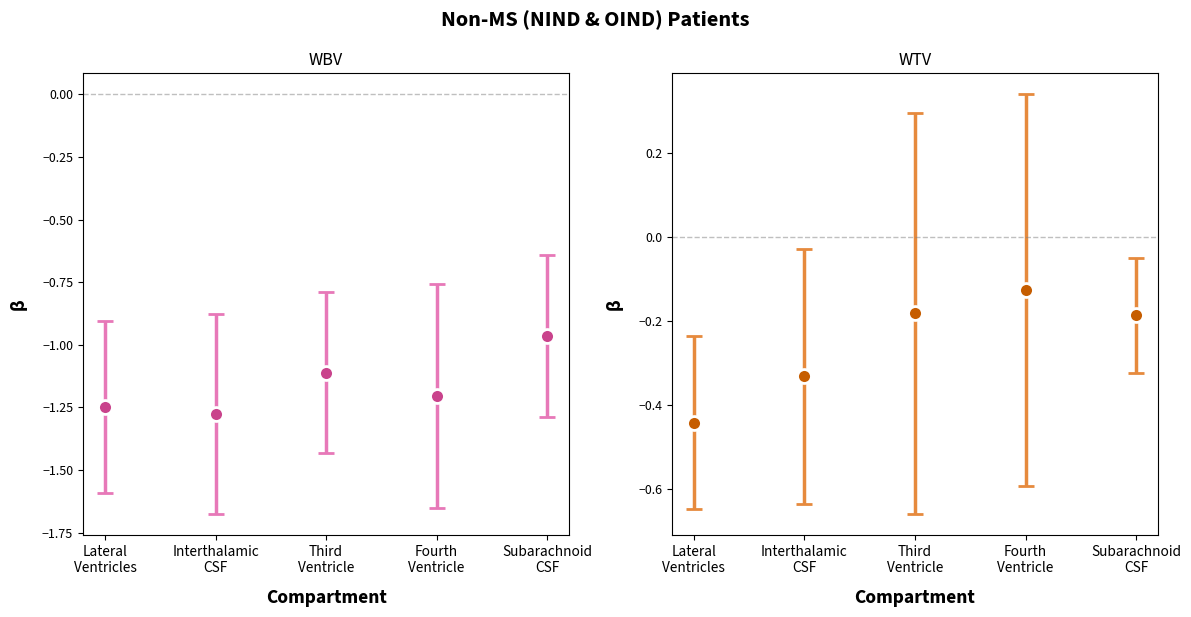

In [49]:
control_name = "basic"
predictor = "WBV"
result = all_results[control_name][predictor]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
plot_csf_compartment_results(
    all_results,
    predictor,
    control_name,
    title=None,
    ax_title=None,
    point_color=colors["dark pink1"],
    ecolor=colors["light pink1"],
    line_color=colors["darkest red2"],
    connect_points=False,
    legend_label="WBV",
    fig=fig,
    ax=ax
)
ax.set_title("WBV", fontsize=13)


predictor = "WTV"
result = all_results[control_name][predictor]
ax = axes[1]
plot_csf_compartment_results(
    all_results,
    predictor,
    control_name,
    title=None,
    ax_title=None,
    point_color=colors["dark orange2"],
    ecolor=colors["light orange2"],
    line_color=colors["darkest red2"],
    connect_points=False,
    legend_label="WBV",
    fig=fig,
    ax=ax
)
ax.set_title("WTV", fontsize=13)

fig.suptitle("Non-MS (NIND & OIND) Patients", fontweight='bold', y=1.02, fontsize=16)

```R
outcome ~ WTV + age + Female + tiv
```


| outcome      |    coef |   p_fdr |     se | ci                |    R2 |
|:-------------|--------:|--------:|-------:|:------------------|------:|
| LV_log       | -0.4416 | 0.00014 | 0.1053 | [-0.648, -0.235]  | 0.49  |
| interCSF_log | -0.3319 | 0.053   | 0.1548 | [-0.635, -0.0286] | 0.17  |
| thirdV_log   | -0.1825 | 0.57    | 0.2434 | [-0.66, 0.295]    | 0.25  |
| fourthV_log  | -0.1267 | 0.59    | 0.2373 | [-0.592, 0.338]   | 0.075 |
| periCSF_log  | -0.1863 | 0.019   | 0.0697 | [-0.323, -0.0497] | 0.65  |

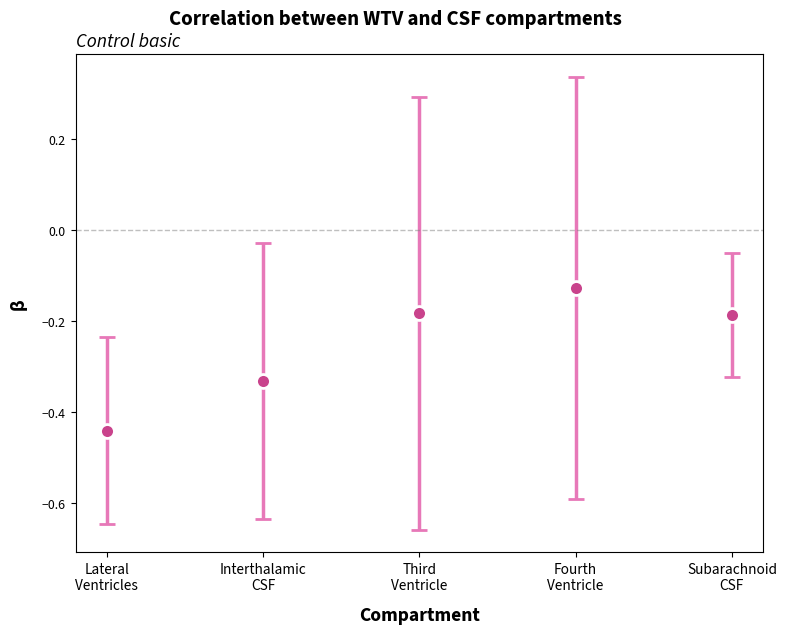

In [25]:
control_name = "basic"
predictor = "WTV"
result = all_results[control_name][predictor]
display_csf_compartment_results(all_results, all_covariates, predictor, control_name)

fig, ax = plot_csf_compartment_results(
    all_results,
    predictor,
    control_name,
    point_color=colors["dark pink1"],
    ecolor=colors["light pink1"],
    line_color=colors["darkest red2"],
    connect_points=False,
    legend_label="WBV"
)


### Plotting CP vs CSF compartments, various controls


In [ ]:
# plot configurations
sup_title_y = 1.05

model_data = zscore(data[MS_patients].copy())
model_formulations = {
    "basic": ["age", "Female", "tiv"],
    "WBV": ["WBV", "Female", "tiv"],
}
predictors = ["CP", "T2LV_log1p"]
csf_compartments = [
    "LV_log",
    "interCSF_log",
    "thirdV_log",
    "fourthV_log",
    "periCSF_log",
]

all_results = {}
all_models = {}
for name, covariates in model_formulations.items():
    _, all_results[name], all_models[name] = regutils.run_regressions(
        model_data, outcomes, predictors, covariates
    )

predictor = "CP"
control_name = "basic"
plot_data = all_results[control_name][predictor]
save_name = f"Correlations between {predictor} and CSF - {name} control.png"
fig, ax = plot_betas(
    coefficients=plot_data["coef"],
    lower_ci=plot_data["llci"],
    upper_ci=plot_data["ulci"],
    labels=[
        "Lateral\nVentricles",
        "Interthalamic\nCSF",
        "Third\nVentricle",
        "Fourth\nVentricle",
        "Subarachnoid\nCSF",
    ],
    title=None,
    ylabel=f"β of {predictor}",
    connect_points=False,
    fig_transparent=False,
    axs_transparent=False,
)
title = f"Correlation between {predictor} and CSF compartments"
fig.suptitle(
    title, fontsize=15, fontweight="bold", y=sup_title_y
)  # Adjust y position if needed
ax.set_title(f"Control {control_name}", fontsize=14, fontstyle="italic", loc="left")

fig.savefig(fig_path / save_name, dpi=300, bbox_inches="tight", transparent=False)
plt.show()


predictor = "CP"
control_name = "WBV"
plot_data = all_results[control_name][predictor]
save_name = f"Correlations between {predictor} and CSF - {name} control.png"

fig, ax = plot_betas(
    coefficients=plot_data["coef"],
    lower_ci=plot_data["llci"],
    upper_ci=plot_data["ulci"],
    labels=[
        "Lateral\nVentricles",
        "Interthalamic\nCSF",
        "Third\nVentricle",
        "Fourth\nVentricle",
        "Subarachnoid\nCSF",
    ],
    ylabel=f"β of {predictor}",
    title=None,
    connect_points=False,
    fig_transparent=False,
    axs_transparent=False,
)
# fig.suptitle(title, loc='left')
title = f"Correlation between {predictor} and CSF compartments"
fig.suptitle(
    title, fontsize=15, fontweight="bold", y=sup_title_y
)  # Adjust y position if needed
ax.set_title(f"Control {control_name}", fontsize=14, fontstyle="italic", loc="left")
fig.savefig(fig_path / save_name, dpi=300, bbox_inches="tight", transparent=False)

In [152]:
disease_group = "MS"
influenced_var = "CCR2_log"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

covariates = ["WBV", "age", "Female", "tiv"]
results = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [ ]:
pearson_results, thalamus_comps, nuclei_comps = results
display(Markdown(f"##### Patients with {disease_group}"))

display(
    Markdown(
        f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"
    )
)
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### Patients with MS

**Pearson correlations of residualized thalamic nuclei and CCR2_log:**

```visualprolog
THALAMUS_1: r=-0.29, p=1.53e-10
medial: r=-0.397, p=3.84e-19
posterior: r=-0.315, p=2.96e-12
anterior: r=-0.118, p=1.04e-02
ventral: r=-0.0301, p=5.16e-01
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
+ medial > THALAMUS_1: p=7.47e-06
  posterior = THALAMUS_1: p=2.44e-01
- anterior < THALAMUS_1: p=8.93e-05
- ventral < THALAMUS_1: p=4.04e-22
```



**Comparisons between thalamic nuclei:**

```diff
+ medial > posterior: p=8.02e-03
+ medial > anterior: p=2.94e-09
+ medial > ventral: p=2.05e-19
+ posterior > anterior: p=1.91e-05
+ posterior > ventral: p=4.33e-11
  anterior = ventral: p=6.97e-02
```


In [172]:
disease_group = "MS"
influenced_var = "CP"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

covariates = ["WBV", "CCR", "age", "Female", "tiv"]
results = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [ ]:
pearson_results, thalamus_comps, nuclei_comps = results
display(Markdown(f"##### Patients with {disease_group}"))

display(
    Markdown(
        f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"
    )
)
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### Patients with MS

**Pearson correlations of residualized thalamic nuclei and CP:**

```visualprolog
THALAMUS_1: r=-0.0304, p=5.12e-01
medial: r=-0.0928, p=4.47e-02
posterior: r=-0.0945, p=4.11e-02
anterior: r=0.0206, p=6.57e-01
ventral: r=0.107, p=2.04e-02
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
+ medial > THALAMUS_1: p=1.86e-02
+ posterior > THALAMUS_1: p=5.57e-03
  anterior = THALAMUS_1: p=2.64e-01
- ventral < THALAMUS_1: p=3.37e-07
```



**Comparisons between thalamic nuclei:**

```diff
  medial = posterior: p=9.63e-01
+ medial > anterior: p=2.35e-02
+ medial > ventral: p=2.04e-06
+ posterior > anterior: p=1.66e-02
+ posterior > ventral: p=5.14e-06
  anterior = ventral: p=7.58e-02
```


### So linters stfu about unused imports

I might want to use these ones at some point

In [ ]:
pyperclip
re
smf
stats
StringIO
presentation_cols_both_ps